# LSTM

In [1]:
import re
import nltk
from nltk.tokenize import sent_tokenize

import glob
import textwrap
from wordcloud import WordCloud

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers, layers
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Input
import tensorflow.keras.utils as ku
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

## My Harry Potter small trial corpus

Based on https://www.geeksforgeeks.org/lstm-based-poetry-generation-using-nlp-in-python/ .

**Generating words one by one - based on the idea that word (not letter) is our smallest element.**

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Data preparation

In [3]:
with open('Harry_Potter_i_Zakon_Feniksa.txt', 'r', encoding='cp1250') as f:
  harry = f.read()
  f.close()

type(harry)

str

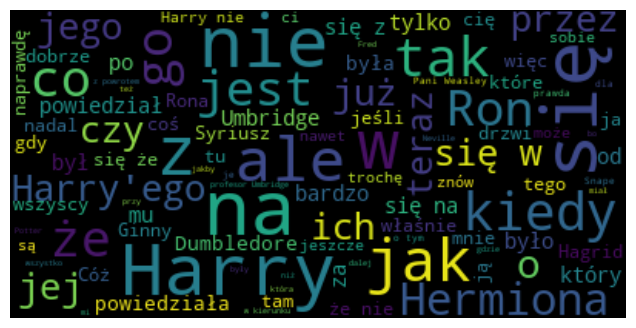

In [4]:
wordcloud = WordCloud(max_font_size=50,
					max_words=100,
					background_color="black").generate(harry)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("WordCloud2.png")
plt.show()

In [5]:
# removing chapter names

def remove_chapter_names(input_string, regex_string):
  a1 = input_string
  a2 = re.sub(rf'{regex_string}', '', a1)
  return a2

In [6]:
counter = 0
for match in re.finditer('ROZDZIAŁ', harry):
    counter += 1
print("We have", counter, "chapters in Harry Potter book.")

We have 38 chapters in Harry Potter book.


In [7]:
harry2 = remove_chapter_names(harry, 'ROZDZIAŁ[^\n]+')

In [8]:
#switch to lower letters - less letters - to delete?
harry3 = harry2.lower()
# chars = sorted(list(set(harry2)))
# len(chars)

In [9]:
#split to sentences
harry_sentences = sent_tokenize(harry3)

harry_sentences[:10]

['\n\n \n\ndudley obłąkany\nnajgorętszy jak dotąd dzień tego lata zbliżał się ku końcowi i senna cisza otulała duże, kwadratowe domy przy privet drive.',
 'lśniące zwykle samochody stały zakurzone na podjazdach, a szmaragdowe niegdyś trawniki pożółkły i wyschły - jako że używanie węży do podlewania zostało zakazane w związku z suszą.',
 'oderwani od swych zwykłych zajęć - mycia samochodów i podlewania trawników - mieszkańcy privet drive wycofali się w cień swoich chłodnych domów, otwierając jedynie szeroko okna w nadziei na przyciągnięcie nieistniejących powiewów wiatru.',
 'jedyną osobą na zewnątrz, był nastoletni chłopiec, który leżał płasko na plecach pośrodku klombu przy domu numer cztery.',
 'był szczupłym, ciemnowłosym chłopcem w okularach, który miał ten znękany, lekko niezdrowy wygląd kogoś, kto znacznie urósł w krótkim okresie czasu.',
 'spodnie miał podarte i brudne, koszulkę rozciągniętą i wypłowiałą, a podeszwy jego butów odrywały się przy czubkach.',
 "wygląd harry'ego pot

In [10]:
#removing newline characters

harry_sentences_clean = []
for sentence in harry_sentences:
  sen = harry_sentences_clean.append(re.sub('\n', '', sentence))
harry_sentences_clean[:10]

[' dudley obłąkanynajgorętszy jak dotąd dzień tego lata zbliżał się ku końcowi i senna cisza otulała duże, kwadratowe domy przy privet drive.',
 'lśniące zwykle samochody stały zakurzone na podjazdach, a szmaragdowe niegdyś trawniki pożółkły i wyschły - jako że używanie węży do podlewania zostało zakazane w związku z suszą.',
 'oderwani od swych zwykłych zajęć - mycia samochodów i podlewania trawników - mieszkańcy privet drive wycofali się w cień swoich chłodnych domów, otwierając jedynie szeroko okna w nadziei na przyciągnięcie nieistniejących powiewów wiatru.',
 'jedyną osobą na zewnątrz, był nastoletni chłopiec, który leżał płasko na plecach pośrodku klombu przy domu numer cztery.',
 'był szczupłym, ciemnowłosym chłopcem w okularach, który miał ten znękany, lekko niezdrowy wygląd kogoś, kto znacznie urósł w krótkim okresie czasu.',
 'spodnie miał podarte i brudne, koszulkę rozciągniętą i wypłowiałą, a podeszwy jego butów odrywały się przy czubkach.',
 "wygląd harry'ego pottera bynaj

**As in the example poem case - word is our smallest element. I predict the word based on the set of previous ones. I split text into sentences, then pad each to the size of the longest sentence.**

In [11]:
# Fitting the Tokenizer on the Corpus
tokenizer = Tokenizer()
tokenizer.fit_on_texts(harry_sentences_clean)

# Vocabulary count of the corpus
total_words = len(tokenizer.word_index)

print("Total Words:", total_words)      #number of "signs"

Total Words: 29876


In [12]:
len(harry2.split()) #book is build from more than 240 000 words, having almost 30 000 unique words (probably some of them are used only once)

242860

In [13]:
# Converting the text into embeddings
input_sequences = []
for sentence in harry_sentences_clean:
  #print(sentence)
  token_list = tokenizer.texts_to_sequences([sentence])[0]
  #print(token_list)
  for i in range(1, len(token_list)):
    n_gram_sequence = token_list[:i+1]
    #print(i, n_gram_sequence)
    input_sequences.append(n_gram_sequence)

In [14]:
input_sequences[:5] #each sentence changed to a few sequences, so that each word in a sentence can be the last in a sequence

[[368, 13284],
 [368, 13284, 12],
 [368, 13284, 12, 1236],
 [368, 13284, 12, 1236, 419],
 [368, 13284, 12, 1236, 419, 33]]

In [15]:
#Compute the length of the longest embedding
max_sequence_len = max([len(x) for x in input_sequences])

#Pad all the embeddings to the maximum length using zeros
input_sequences = np.array(pad_sequences(input_sequences,
										maxlen=max_sequence_len,
										padding='pre'))

predictors, label1 = input_sequences[:, :-1], input_sequences[:, -1]
label = ku.to_categorical(label1, num_classes=total_words+1)

In [16]:
predictors[5]  #padding is done in the beggining of the sequence

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [17]:
label1[5], label[5], len(label[5])   #the output word became one-hot encoded

(548, array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 29877)

In [18]:
max_sequence_len  #the longest sentence

226

In [19]:
predictors.shape  #210330 sequences of fixed length 225

(210330, 225)

In [20]:
predictors[0].shape

(225,)

In [21]:
label.shape #210330 "last in a sequence", each one one-hot encoded (one out of total words)

(210330, 29877)

### Simple model, batch = 32

In [ ]:
# from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras import regularizers

# # Building a Bi-Directional LSTM Model
# model = Sequential()
# model.add(Embedding(total_words+1, 100,
# 					input_length=max_sequence_len-1))  #Input_dim (Size of the vocabulary), Output_dim (Dimension of the dense embedding), input_length (Length of input sequences, when it is constant)
# model.add(Bidirectional(LSTM(150, return_sequences=True)))
# model.add(Dropout(0.2))
# model.add(LSTM(100))
# model.add(Dense(total_words+1/2, activation='relu',
# 				kernel_regularizer=regularizers.l2(0.01)))
# model.add(Dense(total_words+1, activation='softmax'))
# model.compile(loss='categorical_crossentropy',
# 			optimizer='adam', metrics=['accuracy'])
# print(model.summary())

In [ ]:
# #model from the classes
# model = keras.Sequential(
#     [
#         keras.Input(shape=(max_sequence_len-1, len(chars))),
#         layers.LSTM(128),
#         layers.Dense(len(chars), activation="softmax"),
#     ]
# )
# optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
# model.compile(loss="categorical_crossentropy", optimizer=optimizer)

In [ ]:
# from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras import regularizers

# #my model - mix
# model = Sequential()
# model.add(Embedding(total_words+1, len(chars),
# 					input_length=max_sequence_len-1))
# model.add(LSTM(100))
# model.add(Dense(total_words+1, activation='softmax'))
# model.compile(loss='categorical_crossentropy',
# 			optimizer='adam', metrics=['accuracy'])
# print(model.summary())

In [22]:
#model from the classes - modified
model = keras.Sequential(
    [
        layers.Input(shape=(max_sequence_len-1,1)),
        layers.LSTM(128),
        layers.Dense(total_words+1, activation="softmax"),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 29877)             3854133   
                                                                 
Total params: 3,920,693
Trainable params: 3,920,693
Non-trainable params: 0
_________________________________________________________________
None


Memory error

In [23]:
history = model.fit(predictors, label, epochs=150, verbose=1)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

https://stackoverflow.com/questions/62916904/failed-copying-input-tensor-from-cpu-to-gpu-in-order-to-run-gatherve-dst-tensor

Solution: generators

In [24]:
type(predictors)

numpy.ndarray

In [25]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        #it would be possible here to additionally normalize the values -> batch_x = batch_x / float(total_words) 
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

train_gen = DataGenerator(predictors, label, 32)
#test_gen = DataGenerator(X_test, y_test, 32))

In [26]:
train_gen.__len__(), len(predictors)/32   #how many batches are possible

(6573, 6572.8125)

In [27]:
train_gen.__getitem__(0)[0].shape, train_gen.__getitem__(0)[1].shape   #first batch

((32, 225), (32, 29877))

In [ ]:
history = model.fit(train_gen, epochs=150, verbose=1)

Test

In [29]:
#model.save("LSTM_batch32.keras")
loaded_model = tf.keras.models.load_model("LSTM_batch32.keras")

In [34]:
seed_text = "Dawno, dawno temu "
next_words = 200
#ouptut_text = ""

for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences(
		[token_list], maxlen=max_sequence_len-1,
	padding='pre')
	predicted = np.argmax(loaded_model.predict(token_list,
										verbose=0), axis=-1)
	output_word = ""

	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break

	seed_text += " " + output_word

print('\n'.join(textwrap.wrap(seed_text, 80)))

Dawno, dawno temu  i miękko i spokój i na kierunku twarzy i z zbliża george
wyglądały i moment ku i oścież i nie nagle i wyglądały zobaczył i czarodziejów
george i dowiedzieć i nogi nagle i gorączkowo i mimo mocno i kinkietu stronę i
wysłowić stało magii i kierując przejściu i myślicie i paskudna i myślicie
odzwierciedleniem w myślodsiewni czujność w myślodsiewni i tonks i ich podjudza
przejściu i stanie george sufit i dowiedzieć i ich wrzeć i spieszyć i wszyscy w
hallu i czarodziejów george w stanie w stanie w uważniej swojej i paskudna
george w kierunku i rezygnować w naszą w stało w ogóle w dowiedzieć w stanie w
stanie w stanie w stanie w stanie w naszą w stanie w naszą sufit w stanie w
bliżej w wrzeć w dowiedzieć w wrzeć uczyć w kierunku w naszą w kierunku w lista
w stanie w stanie w kierunku w naszą które w stanie w stanie które w stanie w
nich które w stanie w stanie w stanie w stanie w kierunku w stanie w kierunku w
stanie w stanie w kierunku cedrikowi w harry'ego harry'ego więc

### Bidirectional advanced model, batch = 32

In [40]:
model2 = Sequential()
model2.add(Input(shape=(max_sequence_len-1,1))) #LSTM requires [samples, time steps, features], means (n_samples, seq_length, 1)
model2.add(Bidirectional(LSTM(150, return_sequences=True)))
model2.add(Dropout(0.2))
model2.add(LSTM(100))
model2.add(Dense(total_words+1, activation='softmax'))
model2.compile(loss='categorical_crossentropy',
			optimizer='adam', metrics=['accuracy'])

print(model2.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 225, 300)         182400    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 225, 300)          0         
                                                                 
 lstm_4 (LSTM)               (None, 100)               160400    
                                                                 
 dense_2 (Dense)             (None, 29877)             3017577   
                                                                 
Total params: 3,360,377
Trainable params: 3,360,377
Non-trainable params: 0
_________________________________________________________________
None


In [42]:
class DataGenerator2(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        #it would be possible here to additionally normalize the values -> batch_x = batch_x / float(total_words) 
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

train_gen2 = DataGenerator2(predictors, label, 32)
#test_gen = DataGenerator(X_test, y_test, 32))

In [43]:
train_gen2.__getitem__(0)[0].shape #LSTM requires [samples, time steps, features], means (n_samples, seq_length, 1)

(32, 225)

In [44]:
train_gen2.__getitem__(0)[1].shape #one-hot on label indicating which word is it from all possible

(32, 29877)

In [ ]:
history2 = model2.fit(train_gen2, epochs=100, verbose=1)

In [45]:
import tensorflow as tf

#model2.save("LSTM_advanced_batch32.keras")
loaded_model2 = tf.keras.models.load_model("LSTM_advanced_batch32.keras")

In [46]:
import textwrap

seed_text = "Za górami za lasami była sobie"
next_words = 200

for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences(
		[token_list], maxlen=max_sequence_len-1,
	padding='pre')
	predicted = np.argmax(loaded_model2.predict(token_list,
										verbose=0), axis=-1)
	output_word = ""

	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break

	seed_text += " " + output_word

print('\n'.join(textwrap.wrap(seed_text, 80)))

Za górami za lasami była sobie się zastanawialiśmy latem całując się na pięcie
nogach i tata się na równe i kolana się w zamyśleniu dziesiątki złowieszczy
dyskusji i zapisując się w migoczącą dziesiątki złowieszczy i jego chatką
zakłopotany i przemokli się w dół i z powrotem w rytmie i rzucał herbata się w
zamyśleniu dziesiątki frontowe się na niego na ułamki zdjęcia się ogniste
szczątki i cichsze się w zamyśleniu niezdrowy katedry dyskusji i jego chatką
wywrócił i przemokli się w migoczącą wodę złowieszczy dyskusji i jego chatką
wywrócił i czekała się w migoczącą wodę rosły ranka i jego świadomości wywrócił
i czekała się w migoczącą wodę rosły się na boki powietrzu zaznaczył się na boki
i w samym i w końcu sposób że nie mógł co mogłoby ignorując czarodziejem w to że
kształt znajomość się skupianie że nie był w stanie przeżuwać pewne się plecami
węższe i w dół sposób w końcu gdzie przewodziła się uczta skręty stwora
rozmawiając i obijających się w migoczącą niezdrowy mgły dyskusji i je

Sounds better, but the ending is looped and there is no dots.

### Check if the steps were right by reading the other article - more focusing on prose text, not poetry: https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/.

Here, the letters are the predicted one by one, not words. The sequences are created in a different way - the length is fixed as 100 and the slide window of this size just goes one by one from the beginning of text to the end.

They lower the letters as well.

They use batches! They have almost 150 000 patterns (samples), use batch size equal to 128 (big one), but only 20 epochs(it gives above 23 000 iterations).

I was operating now on almost 30 000 patterns (samples), using batch size equal to 32 and having 100/150 epochs (above 93 000 iterations).

However their results are quite poor. So they add the second LSTM layer (as I have) and get much better results.

They give an advice to remove any punctuation as a way to improve the results - so I should not worry about my unfinished sentences probably (using word-by-word method).

Other authors:
* https://www.knime.com/blog/text-generation-with-lstm - again, predicting letter by letter
* https://pub.towardsai.net/this-is-how-i-utilize-ai-to-create-one-of-a-kind-fairytales-d84bde347b5 - the same approach, slide window of length 100 + a lot of books used
* Article https://www.cs.utoronto.ca/~ilya/pubs/2011/LANG-RNN.pdf is a base for this kind of models, they use letter-by-letter generation, but also have much bigger dataset (> 300 MB, whereas my Harry Potter is barely 1.5 MB)

### Other way of preparing the dataset - treating some punctuations as words.

In [49]:
#read from file
with open('Harry_Potter_i_Zakon_Feniksa.txt', 'r', encoding='cp1250') as f:
  harry = f.read()
  f.close()

# remove chapter names
def remove_chapter_names(input_string, regex_string):
  a1 = input_string
  a2 = re.sub(rf'{regex_string}', '', a1)
  return a2

harry2 = remove_chapter_names(harry, 'ROZDZIAŁ[^\n]+')

In [50]:
harry2[:200]   #string, big letters, \n included

'\n\n \n\nDudley obłąkany\nNajgorętszy jak dotąd dzień tego lata zbliżał się ku końcowi i senna cisza otulała duże, kwadratowe domy przy Privet Drive. Lśniące zwykle samochody stały zakurzone na podjazdach,'

https://stackoverflow.com/questions/49073673/include-punctuation-in-keras-tokenizer

In [51]:
from keras.preprocessing.text import Tokenizer
import re

#Some punctuations are needed
to_exclude = '#$%&()*+/;<=>@[\\]^_`{|}~\t\n'
to_tokenize = '.,:!?"-'
tokenizer2 = Tokenizer(filters=to_exclude)  #lower=True is a default setting

#I will process a string
text = harry2

#I get a space between a word and a punctuation - thanks to this, Tokenizer will not treat done. as a token, but done and . as separate tokens
text = re.sub(r'(['+to_tokenize+'])', r' \1 ', text) 

tokenizer2.fit_on_texts([text])
print(tokenizer2.word_index)
total_words2 = len(tokenizer2.word_index)
print("Total Words:", total_words2)

{'.': 1, ',': 2, '-': 3, 'się': 4, 'i': 5, 'w': 6, 'na': 7, 'nie': 8, 'z': 9, 'że': 10, 'harry': 11, 'to': 12, '?': 13, 'do': 14, '!': 15, 'tak': 16, 'jak': 17, 'ale': 18, 'co': 19, 'po': 20, 'jego': 21, 'powiedział': 22, 'o': 23, 'a': 24, 'jest': 25, 'kiedy': 26, 'przez': 27, 'hermiona': 28, 'za': 29, 'ron': 30, 'go': 31, 'był': 32, 'by': 33, 'tym': 34, "harry'ego": 35, 'jej': 36, 'od': 37, 'tego': 38, 'czy': 39, '"': 40, 'było': 41, 'już': 42, 'umbridge': 43, 'ze': 44, 'profesor': 45, 'powiedziała': 46, 'tylko': 47, 'mu': 48, 'bardzo': 49, 'ich': 50, 'teraz': 51, 'no': 52, 'dumbledore': 53, 'pani': 54, 'sobie': 55, 'weasley': 56, 'gdy': 57, 'który': 58, 'niego': 59, 'syriusz': 60, 'przed': 61, 'on': 62, 'drzwi': 63, 'przy': 64, 'być': 65, 'jeśli': 66, 'coś': 67, 'ja': 68, 'może': 69, 'spytał': 70, 'jeszcze': 71, 'jakby': 72, 'była': 73, 'miał': 74, 'nich': 75, 'ma': 76, 'nim': 77, 'dla': 78, 'siebie': 79, ':': 80, 'mnie': 81, 'wszyscy': 82, 'hagrid': 83, 'więc': 84, 'mi': 85, 'dobrze

Before we had 29876 words, now we have less even though we take punctuation as additional words. Probably before some words got artificially glued together.

In my opinion a network may have a problem if I will repeat the previous method and split the samples by sentences - then will it know what can be the word after the dot having any sample in this schema? I decided to use the method typically used for letter-by-letter generation, so 100-length coded sequences.

In [52]:
sequences2 = tokenizer2.texts_to_sequences(text)
sequences2[:10]  #we got dictionary indexes of each word and relevant punctuation (empty lists stand for the excluded signs)

[[], [], [], [], [], [2957], [326], [2957], [12803], [4877]]

In [53]:
#delete empty lists
sequences2 = [i for i in sequences2 if i!=[]]
sequences2[:10]

[[2957], [326], [2957], [12803], [4877], [23], [2833], [2909], [24], [2700]]

In [54]:
#flatten the list
sequences2 = [item for sublist in sequences2 for item in sublist]
sequences2[:10]

[2957, 326, 2957, 12803, 4877, 23, 2833, 2909, 24, 2700]

In [56]:
len(sequences2)  #number of elements in text

1145131

In [55]:
seq_length = 100
sequences_99 = []
successors = []
for i in range(0, len(sequences2) - seq_length, 1):
	seq_in = sequences2[i:i + seq_length]
	seq_out = sequences2[i + seq_length]
	sequences_99.append(seq_in)
	successors.append(seq_out)
n_patterns = len(sequences_99)
print("Total Patterns: ", n_patterns) #it is total sequences number minus 100 (makes sense)

Total Patterns:  1145031


In [59]:
import numpy as np 
import tensorflow.keras.utils as ku

#conversion to arrays
sequences_99 = np.array(sequences_99)
successors = np.array(successors)

#one-hot encoding - moved to generator because of the memory issue
#successors = ku.to_categorical(successors, num_classes=total_words2+1)

sequences_99.shape, successors.shape

((1145031, 100), (1145031,))

In [60]:
from tensorflow.keras.utils import Sequence
import numpy as np   

class DataGenerator3(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = batch_x / float(total_words2) #normalize the values
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = ku.to_categorical(batch_y, num_classes=total_words2+1)  #added here to release the memory
        return batch_x, batch_y

train_gen3 = DataGenerator3(sequences_99, successors, 32)
#test_gen = DataGenerator(X_test, y_test, 32)

In [61]:
train_gen3.__getitem__(0)[0].shape, train_gen3.__getitem__(0)[1].shape

((32, 100), (32, 29840))

Model as above (with increased units in LSTMs since the samples are smaller and it was adviced on the website).

In [62]:
from tensorflow.keras.layers import Input

model3 = Sequential()
model3.add(Input(shape=(seq_length-1,1))) #LSTM requires [samples, time steps, features], means (n_samples, seq_length, 1)
model3.add(Bidirectional(LSTM(300, return_sequences=True)))
model3.add(Dropout(0.2))
model3.add(LSTM(250))
model3.add(Dense(total_words2+1, activation='softmax'))
model3.compile(loss='categorical_crossentropy',
			optimizer='adam', metrics=['accuracy'])

print(model3.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 99, 600)          724800    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 99, 600)           0         
                                                                 
 lstm_6 (LSTM)               (None, 250)               851000    
                                                                 
 dense_3 (Dense)             (None, 29840)             7489840   
                                                                 
Total params: 9,065,640
Trainable params: 9,065,640
Non-trainable params: 0
_________________________________________________________________
None


In [65]:
history3 = model3.fit(train_gen3, epochs=5, verbose=1)   #one epoch is half an hour - let's test on 5 epochs

Epoch 1/5
35783/35783 [==============================] - 2670s 75ms/step - loss: 2.9577 - accuracy: 0.1302
Epoch 2/5
35783/35783 [==============================] - 1527s 43ms/step - loss: 2.8464 - accuracy: 0.1566
Epoch 3/5
35783/35783 [==============================] - 1518s 42ms/step - loss: 2.8299 - accuracy: 0.1620
Epoch 4/5
35783/35783 [==============================] - 1481s 41ms/step - loss: 2.8311 - accuracy: 0.1611
Epoch 5/5
35783/35783 [==============================] - 1424s 40ms/step - loss: 2.8155 - accuracy: 0.1660


In [66]:
import tensorflow as tf

model3.save("LSTM_advanced_batch32_seq100.keras")
loaded_model3 = tf.keras.models.load_model("LSTM_advanced_batch32_seq100.keras")

Tokenization check

In [67]:
seed_text = "za górami za lasem była sobie"
to_tokenize = '.,:!?"-'
seed_text = re.sub(r'(['+to_tokenize+'])', r' \1 ', seed_text) #punctuation
print(seed_text)
seed_text = tokenizer2.texts_to_sequences([seed_text])[0] #codes just the words it has in the dictionary
print(seed_text)

za górami za lasem była sobie
[29, 29055, 29, 27845, 73, 55]


In [68]:
tokenizer2.word_index['p'] #strange word

1116

Test - part 1 (short text + padding)

In [69]:
import textwrap

seed_text = "za górami za lasem żył czarodziej, który bardzo lubił być w centrum uwagi"
to_tokenize = '.,:!?"-'
seed_text = re.sub(r'(['+to_tokenize+'])', r' \1 ', seed_text) #punctuation

next_words = 200
seq_length = 100

for _ in range(next_words):
	token_list = tokenizer2.texts_to_sequences([seed_text])[0] #codes just the words it has in the dictionary
	token_list = np.array(token_list) / float(total_words2) #normalize the values
	token_list = pad_sequences(
		[token_list], maxlen=seq_length-1,
		padding='pre')

	predicted = np.argmax(loaded_model3.predict(token_list,
										verbose=0), axis=-1)
	output_word = ""

	for word, index in tokenizer2.word_index.items():
		if index == predicted:
			output_word = word
			break

	seed_text += " " + output_word

print('\n'.join(textwrap.wrap(seed_text, 80)))

za górami za lasem żył czarodziej ,  który bardzo lubił być w centrum uwagi e e
e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e
e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e
e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e
e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e
e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e


## Extending the dataset

So, the first model (training with sentences without artificial fixed length) gave better results (even though for this moment there is no punctuation). Let's see if extending the dataset and training the model on it will return better results (I cannot use the same model as before since now the dictionary needs to be bigger). This time I will leave the punctuation and limit the number of words based on a frequency to 80 000 (the cost is lots of OOV).

https://towardsdatascience.com/word-subword-and-character-based-tokenization-know-the-difference-ea0976b64e17

We have 30 MB of Polish novels (however, quite old ones, so there may be a problem with vocabulary) built from https://clarin-pl.eu/dspace/handle/11321/312 chose from 1000 pieces. I cleaned them manually a little, roughly, mainly elements from the beginning and the end of each file.

https://stackoverflow.com/questions/30041837/how-to-open-multiple-files-one-by-one-and-print-the-contents-in-python

In [74]:
# removing chapter names

def remove_chapter_names(input_string, regex_string):
  a1 = input_string
  a2 = re.sub(rf'{regex_string}', '', a1)
  return a2

In [75]:
sentences_extended = []

for file in glob.glob("30 MB noweli/*"):

    #read the file
    myfile = open(file,"r")
    text = myfile.read()
    myfile.close()

    #clean chapter names
    text = remove_chapter_names(text, 'ROZDZIAŁ[^\n]+')
    text = remove_chapter_names(text, 'Rozdział[^\n]+')

    #lower
    text = text.lower()

    #split to sentences
    text = sent_tokenize(text)
    print("file ", file, " generated ", len(text), " sentences")
    
    sentences_extended.extend(text)
    

file  30 MB noweli\anonim3_agady-talmudyczne.txt  generated  13944  sentences
file  30 MB noweli\brzozowski_legenda-mlodej-polski_1910.txt  generated  5848  sentences
file  30 MB noweli\cervantes_don-kichot-z-la-manchy_1899.txt  generated  10984  sentences
file  30 MB noweli\dolega_bracia-dalcz-i-s.ka_1937.txt  generated  11181  sentences
file  30 MB noweli\kraszewski_bozy-gniew_1886.txt  generated  7054  sentences
file  30 MB noweli\kraszewski_bracia-zmartwychwstancy_1876.txt  generated  7826  sentences
file  30 MB noweli\kraszewski_infantka_1884.txt  generated  7826  sentences
file  30 MB noweli\kraszewski_starosta-warszawski_1877.txt  generated  5762  sentences
file  30 MB noweli\kraszewski_syn_jazdona_1880.txt  generated  8890  sentences
file  30 MB noweli\may_winnetou_1910.txt  generated  12284  sentences
file  30 MB noweli\montaigne_proby-ksiega-II_1957.txt  generated  5628  sentences
file  30 MB noweli\montesquieu_o-duchu-praw_1927.txt  generated  8317  sentences
file  30 MB now

In [76]:
print("In total we got", len(sentences_extended), "sentences.")

In total we got 285068 sentences.


In [5]:
sentences_extended[:3]

['agada i przypowieść\n\njeśli chcesz poznać stwórcę świata, czytaj agadę.',
 'przez nią zrozumiesz istotę boga, oby był błogosławiony.',
 'dzięki niej będziesz wiedział, jak się zachować i kroczyć jego drogami.']

In [77]:
#Some punctuation needed

to_exclude = '#$%&()*+/;<=>@[\\]^_`{|}~\t\n'
to_tokenize = '-—.,:!?"'
max_num_words = 80000

tokenizer_extended2 = Tokenizer(num_words=max_num_words, filters=to_exclude)  #lower=True is a default setting

#Get a space between a word and a punctuation (new sentences set)
sentences_extended2 = []
for s in sentences_extended:
    s2 = re.sub(r'(['+to_tokenize+'])', r' \1 ', s)
    sentences_extended2.append(s2)
print("Number of sentences:", len(sentences_extended2))

continuous_text = " ".join(sentences_extended2)
print("Words of the texts: ", len(continuous_text.split()))
tokenizer_extended2.fit_on_texts([continuous_text])
total_words_extended2 = len(tokenizer_extended2.word_index)
print("Total Unique Words:", total_words_extended2)

Number of sentences: 285068
Words of the texts:  5261075
Total Unique Words: 247811


https://stackoverflow.com/questions/46202519/keras-tokenizer-num-words-doesnt-seem-to-work

In [78]:
list(tokenizer_extended2.word_index.keys())[:13]

[',', '.', 'i', 'się', '—', 'w', 'nie', 'na', 'z', 'do', 'to', 'że', '!']

In [79]:
# Converting the text into embeddings
sequences_extended = []
for sentence in sentences_extended2:
  token_list = tokenizer_extended2.texts_to_sequences([sentence])[0]
  for i in range(1, len(token_list)):
    n_gram_sequence = token_list[:i+1]
    sequences_extended.append(n_gram_sequence)
print(len(sequences_extended), "sequences produced.")

4746051 sequences produced.


In [80]:
sequences_extended[:5]

[[75164, 3],
 [75164, 3, 17652],
 [75164, 3, 17652, 103],
 [75164, 3, 17652, 103, 505],
 [75164, 3, 17652, 103, 505, 895]]

In [81]:
#Compute the length of the longest embedding
max_sequence_extended_len = max([len(x) for x in sequences_extended])

#Pad all the embeddings to the maximum length using zeros
sequences_extended = np.array(pad_sequences(sequences_extended,
										maxlen=max_sequence_extended_len,
										padding='pre'))

predictors_extended, label1_extended = sequences_extended[:, :-1], sequences_extended[:, -1]
#labels_extended = ku.to_categorical(label1_extended, num_classes=max_num_words+1)
#memory problem during ku.to_categorical -> categorization moved to Generator
max([x for x in label1_extended]) 

79999

In [82]:
max_sequence_extended_len

371

Simple model, let's test 5 epochs with the big database.

In [ ]:
# from tensorflow.keras.layers import Input

# model_extended = Sequential()
# model_extended.add(Input(shape=(max_sequence_extended_len-1,1))) #LSTM requires [samples, time steps, features], means (n_samples, seq_length, 1)
# model_extended.add(Bidirectional(LSTM(100, return_sequences=True)))
# model_extended.add(Dropout(0.2))
# model_extended.add(LSTM(50))
# model_extended.add(Dense(max_num_words+1, activation='softmax'))
# model_extended.compile(loss='categorical_crossentropy',
# 			optimizer='adam', metrics=['accuracy'])

# print(model_extended.summary())

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

#model from the classes - modified
model_extended = keras.Sequential(
    [
        layers.Input(shape=(max_sequence_extended_len-1,1)),
        layers.LSTM(128),
        layers.Dense(max_num_words+1, activation="softmax"),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
model_extended.compile(loss="categorical_crossentropy", optimizer=optimizer)
print(model_extended.summary())

In [83]:
from tensorflow.keras.utils import Sequence
import numpy as np   

class DataGeneratorExtended(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        #it would be possible here to additionally normalize the values -> batch_x = batch_x / float(total_words) 
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = ku.to_categorical(batch_y, num_classes=max_num_words+1)  #added here to release the memory
        return batch_x, batch_y

train_gen_extended = DataGeneratorExtended(predictors_extended, label1_extended, 32)
#test_gen = DataGenerator(X_test, y_test, 32))

In [ ]:
history_extended = model_extended.fit(train_gen_extended, epochs=5, verbose=1)

In [84]:
#model_extended.save("LSTM_batch32_extended.keras")
loaded_model_extended = tf.keras.models.load_model("LSTM_batch32_extended.keras")

In [85]:
seed_text = "Za górami za lasami była sobie"
next_words = 200

for _ in range(next_words):
	token_list = tokenizer_extended2.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences(
		[token_list], maxlen=max_sequence_extended_len-1,
	padding='pre')
	predicted = np.argmax(loaded_model_extended.predict(token_list,
										verbose=0), axis=-1)
	output_word = ""

	for word, index in tokenizer_extended2.word_index.items():
		if index == predicted:
			output_word = word
			break

	seed_text += " " + output_word

print('\n'.join(textwrap.wrap(seed_text, 80)))

Za górami za lasami była sobie , parskanie , a więc , że mogę , a jakże ducha
zaś , a drugi , jak czym koni , to które , które roli roli chorągwi zaś jest żem
, jakby często zaś , parskanie , a sześć , że czym , a gdyby , a gdyby , a czym
, bo które roli , że czym , które , a gdyby , a czym , że czym , a mogę , bo żem
, które roli , parskanie , to żem , a wasze , a mogę wtóre , które roli , które
izmael , a czym porucznika . . , a czym , jak czym , a mogę , które izmael
izmael , a żem , które roli roli , a mogę , a tłumaczyć , którzy jest izmael , a
hm porucznika . . , a czym , jak czym , że czym jest , że mogę , które jakbym ,
kiedy kazał ze , pozwoli jak , a mogę , a czym , a gdyby , a czym , a mogę ,
kiedy a żem , jaką , którzy jest , które co , a mogę . . . a których , a czym


Stop words are on the top, as the most frequent words, they appear the most often. Removing them may not be a good idea, though:  https://michael-fuchs-python.netlify.app/2021/05/25/nlp-text-pre-processing-ii-tokenization-and-stop-words/ ?

## Maybe this way: https://towardsdatascience.com/text-generation-gpt-2-lstm-markov-chain-9ea371820e1e .

I will focus on less data, but more fairytale language.

Corresponding code: https://github.com/klaudia-nazarko/nlg-text-generation/blob/main/lstm.ipynb.

In [86]:
# removing chapter names

def remove_chapter_names(input_string, regex_string):
  a1 = input_string
  a2 = re.sub(rf'{regex_string}', '', a1)
  return a2

In [87]:
sentences_tales = []

for file in glob.glob("Korpusy do bajek/*"):

    try:
        #read the file
        myfile = open(file,"r")
        text = myfile.read()
        myfile.close()

        #clean chapter names
        text = remove_chapter_names(text, 'ROZDZIAŁ[^\n]+')
        text = remove_chapter_names(text, 'Rozdział[^\n]+')

        #lower
        text = text.lower()

        #split to sentences
        text = sent_tokenize(text)
        print("file ", file, " generated ", len(text), " sentences")
        
        sentences_tales.extend(text)
    except:
       continue
    

file  Korpusy do bajek\2261__dzieciaki_i_spolka_.txt  generated  576  sentences
file  Korpusy do bajek\3867_szklarski-alfred_tomek-u-zrodel-amazonki.txt  generated  7119  sentences
file  Korpusy do bajek\920_przygody_sindbada_zeglarza.txt  generated  5008  sentences
file  Korpusy do bajek\andersen_brzydkie-kaczatko_1908.txt  generated  314  sentences
file  Korpusy do bajek\andersen_calineczka.txt  generated  286  sentences
file  Korpusy do bajek\andersen_choinka.txt  generated  275  sentences
file  Korpusy do bajek\andersen_cien_1899.txt  generated  329  sentences
file  Korpusy do bajek\andersen_cos_1899.txt  generated  173  sentences
file  Korpusy do bajek\andersen_czerwone-buciki_1899.txt  generated  145  sentences
file  Korpusy do bajek\andersen_dziecie-elfow_1899.txt  generated  274  sentences
file  Korpusy do bajek\andersen_dzikie-labedzie.txt  generated  217  sentences
file  Korpusy do bajek\andersen_dzwony.txt  generated  107  sentences
file  Korpusy do bajek\andersen_historia-r

In [88]:
sentences_tales[:10] #not the best result, but this is a quick test

['- tuf – sapnął pociąg, oznajmiając wszem i wobec wszystkim spóźnialskim, że nadeszła ostatnia chwila aby wskoczyć do swojego przedziału i odjechać w siną dal\n\nlokomotywa ospale ruszyła, pociągając za sobą powoli doczepione wagony\n\nsiedmioletnia mania i dziesięcioletni jurek jechali na swoje pierwsze wakacje bez mamy i taty.',
 'oczywiście do babci jadzi eskortował ich dziadek tadek, ale fajny dziadek to nie to samo co strofująca swoje dzieci co chwilę mama\n\n- tato tylko uważaj na nie!',
 '– krzyknęła mama, żegnająca całą trójkę z perony\n\nmania z jurkiem, wychyleni przez otwarte okno machali mamie, dopóki jej czerwona bluzka nie znikła im w oddali\n\nz początku rodzeństwo zachwycone nowym środkiem transportu siedziało nawet spokojnie, dziadek tadek zamknął okno w przedziale, obciągnął blezer na swoim wydatnym brzuchu, wsadził na nos okulary i oddał się swojej ulubionej lekturze, działu sportowego.',
 'pociąg stukał, pukał, pochylał się na nierównościach, wagon pachniał dziwnie

In [89]:
#Some punctuation needed

to_exclude = '#$%&()*+/;<=>@[\\]^_`{|}~\t\n'
to_tokenize = '-—.,:!?"'
#max_num_words = 80000

tokenizer_tales = Tokenizer(filters=to_exclude)  #lower=True is a default setting

#Get a space between a word and a punctuation (new sentences set)
sentences_tales2 = []
for s in sentences_tales:
    s2 = re.sub(r'(['+to_tokenize+'])', r' \1 ', s)
    sentences_tales2.append(s2)
print("Number of sentences:", len(sentences_tales2))

continuous_tales2 = " ".join(sentences_tales2)
print("Words of the texts: ", len(continuous_tales2.split()))
tokenizer_tales.fit_on_texts([continuous_tales2])
total_words_tales = len(tokenizer_tales.word_index)
print("Total Unique Words:", total_words_tales)

Number of sentences: 99263
Words of the texts:  1533446
Total Unique Words: 104116


In [90]:
tokenizer_tales.index_word

{1: ',',
 2: '.',
 3: '—',
 4: 'i',
 5: 'się',
 6: 'w',
 7: 'na',
 8: 'nie',
 9: 'z',
 10: '!',
 11: 'do',
 12: 'to',
 13: 'że',
 14: 'a',
 15: '?',
 16: 'o',
 17: 'jak',
 18: 'tak',
 19: 'po',
 20: 'ale',
 21: 'co',
 22: 'za',
 23: ':',
 24: 'mi',
 25: 'jej',
 26: 'mnie',
 27: 'jest',
 28: 'go',
 29: 'już',
 30: 'od',
 31: 'gdy',
 32: 'jego',
 33: 'było',
 34: 'tylko',
 35: 'mu',
 36: 'przez',
 37: 'jeszcze',
 38: 'sobie',
 39: 'był',
 40: 'tym',
 41: 'ze',
 42: 'tego',
 43: 'czy',
 44: 'ją',
 45: 'bardzo',
 46: '-',
 47: 'który',
 48: 'dla',
 49: 'teraz',
 50: 'była',
 51: 'ja',
 52: 'pod',
 53: 'więc',
 54: 'ich',
 55: 'lecz',
 56: 'ten',
 57: 'bo',
 58: 'tu',
 59: 'przed',
 60: 'wszystko',
 61: 'pan',
 62: '–',
 63: 'przy',
 64: 'by',
 65: 'może',
 66: 'tam',
 67: 'tej',
 68: 'ci',
 69: 'nic',
 70: 'nim',
 71: 'nawet',
 72: 'jednak',
 73: 'które',
 74: 'potem',
 75: 'je',
 76: 'nad',
 77: 'gdzie',
 78: 'ma',
 79: 'kiedy',
 80: 'ani',
 81: 'on',
 82: 'chwili',
 83: 'aby',
 84: 'też'

This looks like a good samples choice: almost 1.5 million of words, but less than 100 000 unique ones (between 80 000 - 120 000), puntuation included.

In [91]:
sequences_tales = tokenizer_tales.texts_to_sequences(continuous_tales2)
sequences_tales[:15]  #we got dictionary indexes of each word and relevant punctuation (empty lists stand for the excluded signs)

[[],
 [46],
 [],
 [],
 [5153],
 [119],
 [31357],
 [],
 [62],
 [],
 [1288],
 [14],
 [5874],
 [5873],
 []]

In [92]:
#delete empty lists
sequences_tales = [i for i in sequences_tales if i!=[]]
sequences_tales[:15]

[[46],
 [5153],
 [119],
 [31357],
 [62],
 [1288],
 [14],
 [5874],
 [5873],
 [56468],
 [5874],
 [16],
 [16911],
 [4],
 [39648]]

In [93]:
#flatten the list
sequences_tales = [item for sublist in sequences_tales for item in sublist]
sequences_tales[:15]

[46,
 5153,
 119,
 31357,
 62,
 1288,
 14,
 5874,
 5873,
 56468,
 5874,
 16,
 16911,
 4,
 39648]

In [94]:
len(sequences_tales)  #warning! way more than words - lots of additional signs are counted in

6702553

Probably in the model of the same type tested above (fixed sequence length), sequences were too long (100 elements), in the article they suggest the length of 4. Indeed, it makes sense, since they did letter-to-letter generation (100 letters may mean 15 words.)

In [95]:
seq_length_tales = 5
sequences_4 = []
successors_tales = []
for i in range(0, len(sequences_tales) - seq_length_tales, 1):
	seq_in = sequences_tales[i:i + seq_length_tales]
	seq_out = sequences_tales[i + seq_length_tales]
	sequences_4.append(seq_in)
	successors_tales.append(seq_out)
n_patterns_tales = len(sequences_4)
print("Total Patterns: ", n_patterns_tales)

Total Patterns:  6702548


In [96]:
#conversion to arrays
sequences_4 = np.array(sequences_4)
successors_tales = np.array(successors_tales)

sequences_4.shape, successors_tales.shape

((6702548, 5), (6702548,))

In [97]:
type(sequences_4)

numpy.ndarray

I will not use normalization. Also, I will move the one-hot part to the generator. Let's work on a huge batches, as in the article.

In [98]:
from tensorflow.keras.utils import Sequence
import numpy as np   

class DataGeneratorTales(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        #batch_x = batch_x / float(total_words2) #normalize the values
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = ku.to_categorical(batch_y, num_classes=total_words_tales+1)
        return batch_x, batch_y

train_gen_tales = DataGeneratorTales(sequences_4, successors_tales, 512)
#test_gen = DataGenerator(X_test, y_test, 32)

Simple model, similar to theirs

In [70]:
#batch = 512 raises ResourceExhaustedError after 1.5 epochs on 512 LSTM units
#the same with batch = 128

#let's decrease the number of LSTM units
#batch = 512 and LSTM units = 300

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

#model from the classes - modified
model_tales = keras.Sequential(
    [
        layers.Input(shape=(seq_length_tales-1,1)),
        layers.LSTM(300),
        layers.Dense(total_words_tales+1, activation="softmax"),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
model_tales.compile(loss="categorical_crossentropy", optimizer=optimizer)
print(model_tales.summary())

In [ ]:
history_tales = model_tales.fit(train_gen_tales, epochs=10, verbose=1)  
#40 epochs is too long, let's check 10 and train again alternatively

In [99]:
#model_tales.save("LSTM_batch512_tales.keras")
loaded_model_tales = tf.keras.models.load_model("LSTM_batch512_tales.keras")

In [100]:
seed_text = "za górami za lasem żył czarodziej, który bardzo lubił być w centrum uwagi"
to_tokenize = '-—.,:!?"'
seed_text = re.sub(r'(['+to_tokenize+'])', r' \1 ', seed_text) #punctuation

next_words = 200
seq_length_tales = 5

for _ in range(next_words):
	token_list = tokenizer_tales.texts_to_sequences([seed_text])[0] #codes just the words it has in the dictionary
	token_list = token_list[-4:]
	token_list = np.array([token_list])
	# token_list = np.array(token_list) / float(total_words2) #normalize the values
	predicted = np.argmax(loaded_model_tales.predict(token_list,
										verbose=0), axis=-1)
	output_word = ""

	for word, index in tokenizer_tales.word_index.items():
		if index == predicted:
			output_word = word
			break

	seed_text += " " + output_word

print('\n'.join(textwrap.wrap(seed_text, 80)))

za górami za lasem żył czarodziej ,  który bardzo lubił być w centrum uwagi o w
i nadaremnie nadaremnie o w i nadaremnie nadaremnie o w i nadaremnie nadaremnie
o w i nadaremnie nadaremnie o w i nadaremnie nadaremnie o w i nadaremnie
nadaremnie o w i nadaremnie nadaremnie o w i nadaremnie nadaremnie o w i
nadaremnie nadaremnie o w i nadaremnie nadaremnie o w i nadaremnie nadaremnie o
w i nadaremnie nadaremnie o w i nadaremnie nadaremnie o w i nadaremnie
nadaremnie o w i nadaremnie nadaremnie o w i nadaremnie nadaremnie o w i
nadaremnie nadaremnie o w i nadaremnie nadaremnie o w i nadaremnie nadaremnie o
w i nadaremnie nadaremnie o w i nadaremnie nadaremnie o w i nadaremnie
nadaremnie o w i nadaremnie nadaremnie o w i nadaremnie nadaremnie o w i
nadaremnie nadaremnie o w i nadaremnie nadaremnie o w i nadaremnie nadaremnie o
w i nadaremnie nadaremnie o w i nadaremnie nadaremnie o w i nadaremnie
nadaremnie o w i nadaremnie nadaremnie o w i nadaremnie nadaremnie o w i
nadaremnie nadaremnie 

In [101]:
loaded_model_tales.weights  #ok

[<tf.Variable 'lstm/lstm_cell_23/kernel:0' shape=(1, 1200) dtype=float32, numpy=
 array([[-0.19422649,  0.2176553 ,  0.10572506, ..., -0.04226363,
         -0.86039674,  3.1362076 ]], dtype=float32)>,
 <tf.Variable 'lstm/lstm_cell_23/recurrent_kernel:0' shape=(300, 1200) dtype=float32, numpy=
 array([[ 9.6291599e+00, -4.7002840e-01, -1.4562794e+00, ...,
         -6.3171014e-03,  2.3837161e+00, -3.1888103e-01],
        [-1.0774410e+00, -9.9683762e-01, -2.3583465e+00, ...,
          8.1999727e-02,  6.3160553e+00,  4.3018594e-02],
        [ 4.0154080e+00,  1.9637944e+00, -2.2989149e+00, ...,
          2.2378700e+00, -2.9156272e+00,  7.8113145e-01],
        ...,
        [ 6.7040616e-01, -8.4648955e-01,  3.3744550e-01, ...,
          9.1832614e-01, -2.6651087e+00,  1.0003611e+00],
        [-1.1932309e+01, -9.3097234e-01, -1.2785047e-01, ...,
         -1.8376859e+00,  1.1673671e-01, -5.6888957e+00],
        [ 2.7911487e+00, -1.9217376e-02, -1.1852508e-01, ...,
          5.6689906e-01,  6.536

Next epochs.

In [ ]:
train_gen_tales2 = DataGeneratorTales(sequences_4, successors_tales, 512)

In [ ]:
history_tales2 = loaded_model_tales.fit(train_gen_tales2, epochs=10, verbose=1)

In [102]:
#loaded_model_tales.save("LSTM_batch512_tales2.keras")
loaded_model_tales2 = tf.keras.models.load_model("LSTM_batch512_tales2.keras")

In [103]:
seed_text = "za górami za lasem żył czarodziej, który bardzo lubił być w centrum uwagi"
to_tokenize = '-—.,:!?"'
seed_text = re.sub(r'(['+to_tokenize+'])', r' \1 ', seed_text) #punctuation

next_words = 200
seq_length_tales = 5

for _ in range(next_words):
	token_list = tokenizer_tales.texts_to_sequences([seed_text])[0] #codes just the words it has in the dictionary
	token_list = token_list[-4:]
	token_list = np.array([token_list])
	# token_list = np.array(token_list) / float(total_words2) #normalize the values
	predicted = np.argmax(loaded_model_tales2.predict(token_list,
										verbose=0), axis=-1)
	output_word = ""

	for word, index in tokenizer_tales.word_index.items():
		if index == predicted:
			output_word = word
			break

	seed_text += " " + output_word

print('\n'.join(textwrap.wrap(seed_text, 80)))

za górami za lasem żył czarodziej ,  który bardzo lubił być w centrum uwagi
tomek plon o w i nadaremnie plon o w i nadaremnie plon o w i nadaremnie plon o w
i nadaremnie plon o w i nadaremnie plon o w i nadaremnie plon o w i nadaremnie
plon o w i nadaremnie plon o w i nadaremnie plon o w i nadaremnie plon o w i
nadaremnie plon o w i nadaremnie plon o w i nadaremnie plon o w i nadaremnie
plon o w i nadaremnie plon o w i nadaremnie plon o w i nadaremnie plon o w i
nadaremnie plon o w i nadaremnie plon o w i nadaremnie plon o w i nadaremnie
plon o w i nadaremnie plon o w i nadaremnie plon o w i nadaremnie plon o w i
nadaremnie plon o w i nadaremnie plon o w i nadaremnie plon o w i nadaremnie
plon o w i nadaremnie plon o w i nadaremnie plon o w i nadaremnie plon o w i
nadaremnie plon o w i nadaremnie plon o w i nadaremnie plon o w i nadaremnie
plon o w i nadaremnie plon o w i nadaremnie plon o w i nadaremnie plon o w i
nadaremnie plon o w i


In [104]:
loaded_model_tales2.weights #ok

[<tf.Variable 'lstm/lstm_cell_24/kernel:0' shape=(1, 1200) dtype=float32, numpy=
 array([[-1.6278073 ,  0.9994058 ,  0.252452  , ...,  0.90307957,
         -0.63494295,  0.03178265]], dtype=float32)>,
 <tf.Variable 'lstm/lstm_cell_24/recurrent_kernel:0' shape=(300, 1200) dtype=float32, numpy=
 array([[  2.8052363 ,   1.0338007 ,   2.0807967 , ...,   1.0180328 ,
           2.1097236 ,  -0.29105398],
        [ -1.0023139 ,  -1.0574468 ,  -1.9865937 , ...,  -0.59369695,
           5.247537  ,   0.44591364],
        [ 15.505195  ,   0.7122654 ,  -2.5606728 , ...,   2.2949445 ,
          -4.695332  ,   2.6576893 ],
        ...,
        [  1.2325612 ,   1.8696564 ,   1.9674953 , ...,  -2.4465804 ,
          -3.5649457 ,   2.219684  ],
        [-11.788254  ,  -0.77044   ,   2.090477  , ...,  -0.9291453 ,
           0.06371383,  -5.510726  ],
        [  6.853107  ,   0.41992843,  19.86597   , ...,   2.167611  ,
          -0.70080215,   2.4692788 ]], dtype=float32)>,
 <tf.Variable 'lstm/lstm_ce

## Results analysis - so far

##### Harry Potter -> ~ 30 000 unique words among > 240 000 words

**- ATTEMPT 1 -**

sentences & padding

punctuation removed

simple LSTM(128)

150 epochs, batch 32, no normalization

**Result:** okay, lots of "i", repetitions in the end

**- ATTEMPT 2 -**

sentences & padding

punctuation removed

advanced model with bidirectional LSTM layer

100 epochs, batch 32, no normalization

**Result:** better, lots of "i"

**- ATTEMPT 3 -**

fixed sequence of length 100

punctuation is a word

advanced model with bidirectional LSTM layer

5 epochs, batch 32, normalization

**Result:** just one letter

##### 30 MB of Polish novels -> ~ 250 000 unique words among > 5 000 000 words

**- ATTEMPT 1 -**

sentences and padding

punctuation is a word

simple LSTM(128)

5 epochs, batch 32, no normalization

**Result:** text containing almost only stop words and interpunction

##### 10 MB of Polish fairytales and stories -> < 100 000 unique words among ~ 1 500 000 words

**- ATTEMPT 1 -**

fixed sequence of length 5

punctuation is a word

simple LSTM(300)

10 + 10 epochs, batch 512, no normalization

**Result:** only single letters

##### Conclusions: 
1. Firstly, let's check if the testing of fixed sequence model was appropriate. From the 5th attempt source link - hard to say, however from the 3rd attempt source link - looks okay: test input as a sequence of length seq_length-1 (however they do letter-by-letter generation, not word-by-word, so the example is not identical).
2. Secondly, let's assume I want to use the fairytale 10 MB dataset, since it is bigger, the number of unique words seems okay and there are various fairytale-like stories.
3. Thirdly, the worst results were obtained when using fixed sequence method, the best using sentences & padding.
4. First two examples were the best, both had lots of epochs and small batches when using the small dataset. Maybe the same schema would be okay just for the bigger dataset to remove the repetitions. The question is - what to do then with the punctuations (were totally removed in these examples)?
5. Normalization for this moment does not seem helpful.

## Learning from the mistakes

One more time - 10 MB Polish fairytale dataset

Warning - the dataset were later changed a bit and cleaned, that is why eventual discrepancies appear.

In [105]:
# removing chapter names

def remove_chapter_names(input_string, regex_string):
  a1 = input_string
  a2 = re.sub(rf'{regex_string}', '', a1)
  return a2

In [106]:
sentences_stories = []

for file in glob.glob("Korpusy do bajek/*"):

    try:
        #read the file
        myfile = open(file,"r")
        text = myfile.read()
        myfile.close()

        #clean chapter names
        text = remove_chapter_names(text, 'ROZDZIAŁ[^\n]+')
        text = remove_chapter_names(text, 'Rozdział[^\n]+')

        #lower
        text = text.lower()

        #split to sentences
        text = sent_tokenize(text)
        print("file ", file, " generated ", len(text), " sentences")
        
        sentences_stories.extend(text)
    except:
       continue

file  Korpusy do bajek\2261__dzieciaki_i_spolka_.txt  generated  576  sentences
file  Korpusy do bajek\3867_szklarski-alfred_tomek-u-zrodel-amazonki.txt  generated  7119  sentences
file  Korpusy do bajek\920_przygody_sindbada_zeglarza.txt  generated  5008  sentences
file  Korpusy do bajek\andersen_brzydkie-kaczatko_1908.txt  generated  314  sentences
file  Korpusy do bajek\andersen_calineczka.txt  generated  286  sentences
file  Korpusy do bajek\andersen_choinka.txt  generated  275  sentences
file  Korpusy do bajek\andersen_cien_1899.txt  generated  329  sentences
file  Korpusy do bajek\andersen_cos_1899.txt  generated  173  sentences
file  Korpusy do bajek\andersen_czerwone-buciki_1899.txt  generated  145  sentences
file  Korpusy do bajek\andersen_dziecie-elfow_1899.txt  generated  274  sentences
file  Korpusy do bajek\andersen_dzikie-labedzie.txt  generated  217  sentences
file  Korpusy do bajek\andersen_dzwony.txt  generated  107  sentences
file  Korpusy do bajek\andersen_historia-r

In [107]:
sentences_stories[:5]

['- tuf – sapnął pociąg, oznajmiając wszem i wobec wszystkim spóźnialskim, że nadeszła ostatnia chwila aby wskoczyć do swojego przedziału i odjechać w siną dal\n\nlokomotywa ospale ruszyła, pociągając za sobą powoli doczepione wagony\n\nsiedmioletnia mania i dziesięcioletni jurek jechali na swoje pierwsze wakacje bez mamy i taty.',
 'oczywiście do babci jadzi eskortował ich dziadek tadek, ale fajny dziadek to nie to samo co strofująca swoje dzieci co chwilę mama\n\n- tato tylko uważaj na nie!',
 '– krzyknęła mama, żegnająca całą trójkę z perony\n\nmania z jurkiem, wychyleni przez otwarte okno machali mamie, dopóki jej czerwona bluzka nie znikła im w oddali\n\nz początku rodzeństwo zachwycone nowym środkiem transportu siedziało nawet spokojnie, dziadek tadek zamknął okno w przedziale, obciągnął blezer na swoim wydatnym brzuchu, wsadził na nos okulary i oddał się swojej ulubionej lekturze, działu sportowego.',
 'pociąg stukał, pukał, pochylał się na nierównościach, wagon pachniał dziwnie

Let's try with punctuation - since it is very important for the story.

In [108]:
#Some punctuation needed

to_exclude = '#$%&()*+/;<=>@[\\]^_`{|}~\t\n'
to_tokenize = '-—.,:!?"'

tokenizer_stories = Tokenizer(filters=to_exclude)  #lower=True is a default setting

#Get a space between a word and a punctuation (new sentences set)
sentences_stories2 = []
for s in sentences_stories:
    s2 = re.sub(r'(['+to_tokenize+'])', r' \1 ', s)
    sentences_stories2.append(s2)
print("Number of sentences:", len(sentences_stories2))

continuous_stories2 = " ".join(sentences_stories2)
print("Words of the texts: ", len(continuous_stories2.split()))
tokenizer_stories.fit_on_texts([continuous_stories2])
total_words_stories = len(tokenizer_stories.word_index)
print("Total Unique Words:", total_words_stories)

Number of sentences: 99263
Words of the texts:  1533446
Total Unique Words: 104116


In [109]:
# Converting the text into embeddings
sequences_stories = []
for sentence in sentences_stories2:
  token_list = tokenizer_stories.texts_to_sequences([sentence])[0]
  for i in range(1, len(token_list)):
    n_gram_sequence = token_list[:i+1]
    sequences_stories.append(n_gram_sequence)
print(len(sequences_stories), "sequences produced.")

1432915 sequences produced.


In [110]:
#Compute the length of the longest embedding
max_sequence_stories_len = max([len(x) for x in sequences_stories])

#Pad all the embeddings to the maximum length using zeros
sequences_stories = np.array(pad_sequences(sequences_stories,
										maxlen=max_sequence_stories_len,
										padding='pre'))

predictors_stories, label1_stories = sequences_stories[:, :-1], sequences_stories[:, -1]
#labels_extended = ku.to_categorical(label1_extended, num_classes=max_num_words+1)
#memory problem during ku.to_categorical -> try to categorize in Generator
print("The longest sentence has", max_sequence_stories_len, "words.")

The longest sentence has 227 words.


In [111]:
predictors_stories

array([[    0,     0,     0, ...,     0,     0,    46],
       [    0,     0,     0, ...,     0,    46, 55464],
       [    0,     0,     0, ...,    46, 55464,    62],
       ...,
       [    0,     0,     0, ...,    23,   134,   318],
       [    0,     0,     0, ...,   134,   318,     4],
       [    0,     0,     0, ...,   318,     4,    51]])

Simple model

In [123]:
#model from the classes - modified
model_stories = keras.Sequential(
    [
        layers.Input(shape=(max_sequence_stories_len-1,1)),
        layers.LSTM(128),
        layers.Dense(total_words_stories+1, activation="softmax"),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
model_stories.compile(loss="categorical_crossentropy", optimizer=optimizer)
print(model_stories.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 128)               66560     
                                                                 
 dense_4 (Dense)             (None, 104117)            13431093  
                                                                 
Total params: 13,497,653
Trainable params: 13,497,653
Non-trainable params: 0
_________________________________________________________________
None


Generator, batch 32 to check

In [112]:
class DataGeneratorStories(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        #it would be possible here to additionally normalize the values -> batch_x = batch_x / float(total_words) 
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = ku.to_categorical(batch_y, num_classes=total_words_stories+1)  #added here to release the memory
        return batch_x, batch_y

train_gen_stories = DataGeneratorStories(predictors_stories, label1_stories, 32)
#test_gen = DataGenerator(X_test, y_test, 32))

20 epochs, because it is already 8h.

In [ ]:
history_stories = model_stories.fit(train_gen_stories, epochs=20, verbose=1)

In [125]:
#model_stories.save("LSTM_batch32_stories.keras")
loaded_model_stories = tf.keras.models.load_model("LSTM_batch32_stories.keras")

Test

In [132]:
loaded_model_stories.input.shape[1]

193

In [128]:
#max_sequence_stories_len

In [134]:
seed_text = "Za górami za lasami była sobie"
next_words = 200

for _ in range(next_words):
	token_list = tokenizer_stories.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences(
		[token_list], maxlen=loaded_model_stories.input.shape[1],   #strange saving
		padding='pre')
	predicted = np.argmax(loaded_model_stories.predict(token_list,
										verbose=0), axis=-1)
	output_word = ""

	for word, index in tokenizer_stories.word_index.items():
		if index == predicted:
			output_word = word
			break

	seed_text += " " + output_word

print('\n'.join(textwrap.wrap(seed_text, 80)))

Za górami za lasami była sobie na na na na na na na na na na na na na na na na
na na na na na na na na na na na na na na na na na na na na na na na na na na na
na na na na na na na na na na na na na na na na na na na na na na na na na na na
na na na na na na na na na na na na na na na na na na na na na na na na na tej
tej tej tej tej tej tej tej tej tej tej tej tej tej tej tej tej tej tej tej tej
tej tej tej tej tej tej tej tej tej tej tej tej tej tej tej tej tej tej tej tej
tej tej tej tej tej tej tej tej tej tej tej tej tej tej tej tej tej tej tej tej
tej tej tej tej tej tej tej tej tej tej tej tej tej tej tej tej tej tej tej tej
tej tej tej tej tej tej jak jak wszystko wszystko że że teraz rzekła rzekła
rzekła rzekła na na na teraz mimowoli przelazł odezwał


Training for next 30 epochs, small randomization in Generator

In [135]:
import tensorflow as tf

#model_stories.save("LSTM_batch32_stories.keras")
loaded_model_stories2 = tf.keras.models.load_model("LSTM_batch32_stories.keras")

In [136]:
from tensorflow.keras.utils import Sequence
import numpy as np   

class DataGeneratorStories2(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set[15:], y_set[15:]   #change here to mix the previous batches a little
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        #it would be possible here to additionally normalize the values -> batch_x = batch_x / float(total_words) 
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = ku.to_categorical(batch_y, num_classes=total_words_stories+1)  #added here to release the memory
        return batch_x, batch_y

train_gen_stories2 = DataGeneratorStories2(predictors_stories, label1_stories, 32)
#test_gen = DataGenerator(X_test, y_test, 32))

In [ ]:
history_stories2 = loaded_model_stories2.fit(train_gen_stories2, epochs=30, verbose=1)

In [137]:
import tensorflow as tf

#loaded_model_stories2.save("LSTM_batch32_stories2.keras")
loaded_model_stories3 = tf.keras.models.load_model("LSTM_batch32_stories2.keras")

In [138]:
loaded_model_stories3.weights

[<tf.Variable 'lstm_1/lstm_cell_31/kernel:0' shape=(1, 512) dtype=float32, numpy=
 array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, n

In [141]:
seed_text = "Za górami za lasami była sobie"
next_words = 200

for _ in range(next_words):
	token_list = tokenizer_stories.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences(
		[token_list], maxlen=loaded_model_stories3.input.shape[1],
		padding='pre')
	predicted = np.argmax(loaded_model_stories3.predict(token_list,
										verbose=0), axis=-1)
	#print(predicted)
	output_word = ""

	for word, index in tokenizer_stories.word_index.items():
		if index == predicted:
			output_word = word
			break

	seed_text += " " + output_word

print('\n'.join(textwrap.wrap(seed_text, 80)))

Za górami za lasami była sobie


The blank result came from the problem with model weights (nans).

## Better data cleaning + shorter sentences.

I cleaned the text files manually (there were a lot of publishers' notes, numbers, sometimes even links). Visually the data are much more continuous text and finished sentences than before. Some data were gone, so I added a new Verne novel so than it is more than 10 MB again. Szklarski's novel has a lot of footnotes in the middle of the texts, I will remove it using Python.

In [2]:
# removing chapter names
def remove_chapter_names(input_string, regex_string):
    a1 = input_string
    a2 = re.sub(rf'{regex_string}', '', a1)
    return a2

# removing footnotes enclosed in square brackets
def remove_footnotes(input_string):
    a1 = input_string
    a2 = re.sub(r'\[[\d]*\]', '', a1)
    a2 = re.sub(r' \[[^]]*\]', '', a2)
    return a2

# dividing the punctuation with space from the words and removing the double spaces
def divide_punctuation(input_string, punctuation_to_tokenize):
    a1 = input_string
    a2 = re.sub(r'(['+punctuation_to_tokenize+'])', r' \1 ', a1)
    a2 = re.sub(r'  ', r' ', a2)
    return a2

In [3]:
t = "Duże krople deszczu zaszeleściły w gęstwinie amazońskiej selwy [[1]: #_ftnref1 Selva – wilgotny las międzyzwrotnikowy, porasta olbrzymie obszary dorzecza Amazonki.]. W tej właśnie chwili nagle zamilkło monotonne brzęczenie cykad [[2]: #_ftnref1 Cykady (Cicadidae) – piewiki właściwe, należą do grupy pluskwiaków. Żyją głównie w cieplejszych krajach. Żywią się sokami roślin. Długość rozpostartych skrzydeł niektórych gatunków dochodzi do 18 cm. Właściwością cykad jest zdolność wydawania dźwięków za pomocą narządu u nasady odwłoka.]i świerszczy, zamarły przedwieczorne rozhowory papug. "
remove_footnotes(t)                                              

'Duże krople deszczu zaszeleściły w gęstwinie amazońskiej selwy. W tej właśnie chwili nagle zamilkło monotonne brzęczenie cykadi świerszczy, zamarły przedwieczorne rozhowory papug. '

In [4]:
to_tokenize = '-—.,:!?"'
t = "Duże krople deszczu zaszeleściły w gęstwinie amazońskiej selwy [[1]: #_ftnref1 Selva – wilgotny las międzyzwrotnikowy, porasta olbrzymie obszary dorzecza Amazonki.]. W tej właśnie chwili nagle zamilkło monotonne brzęczenie cykad [[2]: #_ftnref1 Cykady (Cicadidae) – piewiki właściwe, należą do grupy pluskwiaków. Żyją głównie w cieplejszych krajach. Żywią się sokami roślin. Długość rozpostartych skrzydeł niektórych gatunków dochodzi do 18 cm. Właściwością cykad jest zdolność wydawania dźwięków za pomocą narządu u nasady odwłoka.]i świerszczy, zamarły przedwieczorne rozhowory papug. "
t = remove_footnotes(t)   
divide_punctuation(t, to_tokenize)

'Duże krople deszczu zaszeleściły w gęstwinie amazońskiej selwy . W tej właśnie chwili nagle zamilkło monotonne brzęczenie cykadi świerszczy , zamarły przedwieczorne rozhowory papug . '

Let's prepare the corpus as one long string. No need to split into sentences - I will clean chapter names, footnotes and deal with punctuation (dividing and removing double spaces) based on the whole file strings.

In [5]:
to_exclude = '#$%&()*+/;<=>@[\\]^_`{|}~\t\n'
to_tokenize = '-—.,:!?"'

corpus_text = []

for file in glob.glob("Korpusy do bajek/*"):

    try:
        #read the file
        myfile = open(file,"r")
        text = myfile.read()
        myfile.close()

        #clean chapter names
        text = remove_chapter_names(text, 'ROZDZIAŁ[^\n]+')
        text = remove_chapter_names(text, 'Rozdział[^\n]+')

        #clean footnotes in square brackets
        text = remove_footnotes(text)

        # divide the punctuation with space from the words and remove the double spaces
        text = divide_punctuation(text, to_tokenize)

        #lower
        text = text.lower()

        #split to sentences
        #text = sent_tokenize(text)
        #print("file ", file, " generated ", len(text), " words")
        
        corpus_text.append(text)
    except:
       continue
    
print("Corpus consists of", len(corpus_text), "text files.")

Corpus consists of 140 text files.


Convert to one string

In [6]:
continuous_corpus = " ".join(corpus_text)
len(continuous_corpus)

8659670

In [7]:
continuous_corpus[:200]

' - tuf – sapnął pociąg , oznajmiając wszem i wobec wszystkim spóźnialskim , że nadeszła ostatnia chwila aby wskoczyć do swojego przedziału i odjechać w siną dal\n\nlokomotywa ospale ruszyła , pociągając'

Create tokenizer

In [8]:
tokenizer_corpus = Tokenizer(filters=to_exclude)
print("Words of the texts: ", len(continuous_corpus.split()))
tokenizer_corpus.fit_on_texts([continuous_corpus])
total_words_corpus = len(tokenizer_corpus.word_index)
print("Total Unique Words:", total_words_corpus)

Words of the texts:  1524877
Total Unique Words: 104228


Create samples - better way, no additional signs

In [9]:
sequences_corpus = tokenizer_corpus.texts_to_sequences([continuous_corpus])[0]
#sequences_corpus = [i for i in sequences_corpus if i!=[]]
#sequences_corpus = [item for sublist in sequences_corpus for item in sublist]

sequences_corpus[:15]

[48, 55403, 65, 12168, 4721, 1, 16348, 21006, 4, 663, 365, 55404, 1, 13, 1310]

A sample will be of length 25.

In [10]:
len(sequences_corpus)

1526657

In [11]:
seq_len_corpus = 25

sequences_24 = []
successors_corpus = []

for i in range(0, len(sequences_corpus) - seq_len_corpus, 1):
	seq_in = sequences_corpus[i:i + seq_len_corpus]
	seq_out = sequences_corpus[i + seq_len_corpus]
	sequences_24.append(seq_in)
	successors_corpus.append(seq_out)
n_patterns_corpus = len(sequences_24)
print("Total Patterns: ", n_patterns_corpus)
sequences_24[0], successors_corpus[0]

Total Patterns:  1526632


([48,
  55403,
  65,
  12168,
  4721,
  1,
  16348,
  21006,
  4,
  663,
  365,
  55404,
  1,
  13,
  1310,
  2389,
  553,
  84,
  21007,
  11,
  1051,
  16349,
  4,
  10404,
  6],
 21008)

The number of patterns is correct.

In [12]:
#conversion to arrays
sequences_24 = np.array(sequences_24)
successors_corpus = np.array(successors_corpus)

sequences_24.shape, successors_corpus.shape

((1526632, 25), (1526632,))

Generator without normalization

In [13]:
class DataGeneratorCorpus(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        #batch_x = batch_x / float(total_words2) #normalize the values
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = ku.to_categorical(batch_y, num_classes=total_words_corpus+1)
        return batch_x, batch_y

train_gen_corpus = DataGeneratorCorpus(sequences_24, successors_corpus, 32)
#test_gen = DataGenerator(X_test, y_test, 32)

Simple model

In [ ]:
#model from the classes - modified
model_corpus = keras.Sequential(
    [
        layers.Input(shape=(seq_len_corpus-1,1)),
        layers.LSTM(128),
        layers.Dense(total_words_corpus+1, activation="softmax"),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
model_corpus.compile(loss="categorical_crossentropy", optimizer=optimizer)
print(model_corpus.summary())

Training

In [ ]:
history_corpus = model_corpus.fit(train_gen_corpus, epochs=25, verbose=1)

Saving

In [155]:
#model_corpus.save("LSTM_batch32_corpus.keras")
loaded_model_corpus = tf.keras.models.load_model("LSTM_batch32_corpus.keras")

Testing

In [156]:
seed_text = "Za górami za lasem żył czarodziej, który bardzo lubił być w centrum uwagi. Pewnego razu przyszedł do księżniczki, a ona bardzo"
to_tokenize = '-—.,:!?"'
seed_text = divide_punctuation(seed_text, to_tokenize)
seed_text = seed_text.lower()

next_words = 200
seq_len_corpus = 25

for _ in range(next_words):
	token_list = tokenizer_corpus.texts_to_sequences([seed_text])[0] #codes just the words it has in the dictionary
	try:
		token_list = token_list[-24:]
	except:
		token_list = pad_sequences([token_list], maxlen=seq_len_corpus-1, padding='pre')
	token_list = np.array([token_list])
	# token_list = np.array(token_list) / float(total_words2) #normalize the values
	# probs = loaded_model_corpus.predict(token_list, verbose=0)
	# print(probs[0][probs[0] == np.max(probs[0])])
	predicted = np.argmax(loaded_model_corpus.predict(token_list, verbose=0), axis=-1)
	output_word = ""

	for word, index in tokenizer_corpus.word_index.items():
		if index == predicted:
			output_word = word
			break

	seed_text += " " + output_word

print('\n'.join(textwrap.wrap(seed_text, 80)))

za górami za lasem żył czarodziej , który bardzo lubił być w centrum uwagi .
pewnego razu przyszedł do księżniczki , a ona bardzo , — w sieni , — w sieni , —
w sieni , — w sieni , — w sieni , — w sieni , — w sieni , — w sieni , — w sieni
, — w sieni , — w sieni , — w sieni , — w sieni , — w sieni , — w sieni , — w
sieni , — w sieni , — w sieni , — w sieni , — w sieni , — w sieni , — w sieni ,
— w sieni , — w sieni , — w sieni , — w sieni , — w sieni , — w sieni , — w
sieni , — w sieni , — w sieni , — w sieni , — w sieni , — w sieni , — w sieni ,
— w sieni , — w sieni , — w sieni , — w sieni , — w sieni , — w sieni , — w
sieni , — w sieni , — w sieni , — w sieni , — w sieni , — w sieni , — w sieni ,
— w sieni , — w sieni


One class is dominant, maybe the dataset is not balanced. The solution can be pos_weights (giving bigger weights to the words that are less frequent), drawing samples randomly and hopefully therefore skipping examples where stopwords are the labels, or trying without punctuation.

Looped predictions - add more layers: https://blog.prokulski.science/2018/03/05/lstm-przewidywanie-tekstu-keras-r/

Looped predictions - drawing randomly the training samples (!), resetting the hidden state ( https://stackoverflow.com/questions/43882796/when-does-keras-reset-an-lstm-state ), drawing from the highest probabilities instead of using argmax, pos_weights (https://stackoverflow.com/questions/45197663/force-positive-weight-keras) if the dataset is not balanced: https://discuss.pytorch.org/t/lstm-text-generator-repeats-same-words-over-and-over/43652 .

But trying to just train for some more epochs for now.

In [ ]:
loaded_model_corpus2 = tf.keras.models.load_model("LSTM_batch32_corpus.keras")

In [ ]:
history_corpus2 = loaded_model_corpus2.fit(train_gen_corpus, epochs=45, verbose=1)

In [157]:
#loaded_model_corpus2.save("LSTM_batch32_corpus2.keras")
loaded_model_corpus3 = tf.keras.models.load_model("LSTM_batch32_corpus2.keras")

In [158]:
seed_text = "Za górami za lasem żył czarodziej, który bardzo lubił być w centrum uwagi. Pewnego razu przyszedł do księżniczki, a ona bardzo"
to_tokenize = '-—.,:!?"'
seed_text = divide_punctuation(seed_text, to_tokenize)
seed_text = seed_text.lower()

next_words = 55
seq_len_corpus = 25

for _ in range(next_words):
	token_list = tokenizer_corpus.texts_to_sequences([seed_text])[0] #codes just the words it has in the dictionary
	try:
		token_list = token_list[-24:]
	except:
		token_list = pad_sequences([token_list], maxlen=seq_len_corpus-1, padding='pre')
	token_list = np.array([token_list])
	# token_list = np.array(token_list) / float(total_words2) #normalize the values
	probs = loaded_model_corpus3.predict(token_list, verbose=0)
	print(probs[0][probs[0] == np.max(probs[0])])
	predicted = np.argmax(probs, axis=-1)
	loaded_model_corpus3.reset_states()   #resetting hidden state here
	
	output_word = ""

	for word, index in tokenizer_corpus.word_index.items():
		if index == predicted:
			output_word = word
			break

	seed_text += " " + output_word

print('\n'.join(textwrap.wrap(seed_text, 80)))

[0.15040384]
[0.19174016]
[0.14946055]
[0.06951226]
[0.12898271]
[0.06890742]
[0.12202424]
[0.06890848]
[0.12771796]
[0.0521375]
[0.09920759]
[0.04149986 0.04149986]
[0.14077614]
[0.10410123]
[0.03917258]
[0.09591428]
[0.04039381 0.04039381]
[0.13144238]
[0.06810865]
[0.13719954]
[0.06562626]
[0.13528876]
[0.06907669]
[0.16235937]
[0.06496679]
[0.16305493]
[0.06620862]
[0.16850992]
[0.06620862]
[0.16850992]
[0.06620862]
[0.16850992]
[0.06620862]
[0.16850992]
[0.06620862]
[0.1767576]
[0.05237595]
[0.9842957]
[0.07152431]
[0.0644635]
[0.2638917]
[0.5456875]
[0.14558326]
[0.3977964]
[0.1257328]
[0.20910367]
[0.10221622]
[0.05137751]
[0.10221622]
[0.05137751]
[0.10221622]
[0.05137751]
[0.10221622]
[0.05137751]
[0.10221622]
za górami za lasem żył czarodziej , który bardzo lubił być w centrum uwagi .
pewnego razu przyszedł do księżniczki , a ona bardzo . jak i jej i jej i jej i
jej i nie rzekłszy i nie nie uwolnij i jej i jej i jej jak jej jak jej jak jej
jak jej jak jej jak jej jak jej pote

Testing - drawing from the highest probabilities instead of using argmax. Look above for more details.

In [159]:
seed_text = "Za górami za lasem żył czarodziej, który bardzo lubił być w centrum uwagi. Pewnego razu przyszedł do księżniczki, a ona bardzo"
to_tokenize = '-—.,:!?"'
seed_text = divide_punctuation(seed_text, to_tokenize)
seed_text = seed_text.lower()

next_words = 55
seq_len_corpus = 25

for _ in range(next_words):
	token_list = tokenizer_corpus.texts_to_sequences([seed_text])[0] #codes just the words it has in the dictionary
	try:
		token_list = token_list[-24:]
	except:
		token_list = pad_sequences([token_list], maxlen=seq_len_corpus-1, padding='pre')
	token_list = np.array([token_list])
	# token_list = np.array(token_list) / float(total_words2) #normalize the values
	probs = loaded_model_corpus3.predict(token_list, verbose=0)
	if len(probs[0][probs[0] > 0.08]) > 0:
		vals = probs[0][probs[0] > 0.08]   #values above 10% probability
		indices_of_vals = [i for i, e in enumerate(probs[0]) if e in vals]
		predicted = random.choice(indices_of_vals)
		print(predicted, "chosen from", indices_of_vals)
	else:
	    predicted = np.argmax(probs, axis=-1)  #if no value is above 10% probability, then take just the maximum existing
	    print("max: ", predicted)
	    
	loaded_model_corpus3.reset_states()   #resetting hidden state here
	
	output_word = ""

	for word, index in tokenizer_corpus.word_index.items():
		if index == predicted:
			output_word = word
			break

	seed_text += " " + output_word

print('\n'.join(textwrap.wrap(seed_text, 80)))

4 chosen from [1, 2, 4, 5]
max:  [25]
4 chosen from [4]
max:  [25]
4 chosen from [4]
max:  [25]
4 chosen from [4]
max:  [25]
4 chosen from [4]
max:  [25]
4 chosen from [4]
max:  [8]
2956 chosen from [2956]
4 chosen from [4]
max:  [8]
8 chosen from [8]
max:  [16512]
4 chosen from [4]
max:  [25]
17 chosen from [4, 17]
max:  [25]
4 chosen from [4, 17]
max:  [25]
17 chosen from [5, 14, 17]
max:  [25]
17 chosen from [5, 14, 17]
max:  [25]
5 chosen from [5, 14, 17]
max:  [25]
5 chosen from [5, 14, 17]
max:  [25]
5 chosen from [5, 14, 17]
max:  [25]
14 chosen from [5, 14, 17]
max:  [25]
17 chosen from [5, 14, 17]
max:  [25]
75 chosen from [75]
max:  [52]
max:  [2]
8 chosen from [8, 17]
2956 chosen from [2956]
17 chosen from [4, 17]
max:  [25]
17 chosen from [4, 17]
max:  [8]
118 chosen from [118]
4 chosen from [4]
max:  [25]
4 chosen from [4]
max:  [25]
4 chosen from [4]
max:  [25]
4 chosen from [4]
max:  [25]
za górami za lasem żył czarodziej , który bardzo lubił być w centrum uwagi .
pewneg

Surprisingly, the maximum values vary more than before. But again it is more less looped. Train again here?

Let's train a little bit more, but this time with sample randomization. Turned out that hidden state is turned off by default and having less than 100 time steps it is not recommended to be used.

In [ ]:
sequences_24, successors_corpus  #all possible sequences of length 25+1

In [ ]:
len(list(range(len(sequences_24)))) == len(sequences_24)

In [ ]:
random.sample(list(range(len(sequences_24))),32) #choices without repetition, shuffle effect

In [14]:
class DataGeneratorCorpusRandom(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        idxs = random.sample(list(range(len(self.x))), self.batch_size)  #here
        batch_x = self.x[idxs]
        #batch_x = batch_x / float(total_words2) #normalize the values
        batch_y = self.y[idxs]
        batch_y = ku.to_categorical(batch_y, num_classes=total_words_corpus+1)
        return batch_x, batch_y

train_gen_corpus_random = DataGeneratorCorpusRandom(sequences_24, successors_corpus, 32)
#test_gen = DataGenerator(X_test, y_test, 32)

In [ ]:
a, b = train_gen_corpus_random.__getitem__(0)
a.shape, b.shape

In [15]:
loaded_model_corpus3 = tf.keras.models.load_model("LSTM_batch32_corpus2.keras")

In [ ]:
history_corpus3 = loaded_model_corpus3.fit(train_gen_corpus_random, epochs=15, verbose=1)

In [16]:
#loaded_model_corpus3.save("LSTM_batch32_corpus3.keras")
loaded_model_corpus4 = tf.keras.models.load_model("LSTM_batch32_corpus3.keras")

In [17]:
seed_text = "Za górami za lasem żył czarodziej, który bardzo lubił być w centrum uwagi. Pewnego razu przyszedł do księżniczki, a ona bardzo"
to_tokenize = '-—.,:!?"'
seed_text = divide_punctuation(seed_text, to_tokenize)
seed_text = seed_text.lower()

next_words = 55
seq_len_corpus = 25

for _ in range(next_words):
	token_list = tokenizer_corpus.texts_to_sequences([seed_text])[0] #codes just the words it has in the dictionary
	try:
		token_list = token_list[-24:] #or -25?
	except:
		token_list = pad_sequences([token_list], maxlen=seq_len_corpus-1, padding='pre')
	token_list = np.array([token_list])
	# token_list = np.array(token_list) / float(total_words2) #normalize the values
	probs = loaded_model_corpus4.predict(token_list, verbose=0)
	print("max prob is: ", max(probs[0]))
	if len(probs[0][probs[0] > 0.07]) > 0:
		vals = probs[0][probs[0] > 0.07]   #values above 10% probability
		indices_of_vals = [i for i, e in enumerate(probs[0]) if e in vals]
		predicted = random.choice(indices_of_vals)
		print(predicted, "chosen from", indices_of_vals)
	else:
	    predicted = np.argmax(probs, axis=-1)  #if no value is above 10% probability, then take just the maximum existing
	    print("max: ", predicted)
	    
	loaded_model_corpus4.reset_states()   #resetting hidden state here
	
	output_word = ""

	for word, index in tokenizer_corpus.word_index.items():
		if index == predicted:
			output_word = word
			break

	seed_text += " " + output_word

print('\n'.join(textwrap.wrap(seed_text, 80)))

max prob is:  0.20086592
5 chosen from [1, 2, 5]
max prob is:  0.07584297
3 chosen from [3]
max prob is:  0.0801954
8 chosen from [8]
max prob is:  0.0317548
max:  [32275]
max prob is:  0.23236513
3 chosen from [3]
max prob is:  0.1683726
8 chosen from [3, 8]
max prob is:  0.081119336
8 chosen from [8]
max prob is:  0.0317548
max:  [32275]
max prob is:  0.23236513
3 chosen from [3]
max prob is:  0.1683726
3 chosen from [3, 8]
max prob is:  0.0801954
8 chosen from [8]
max prob is:  0.0317548
max:  [32275]
max prob is:  0.23236513
3 chosen from [3]
max prob is:  0.1683726
8 chosen from [3, 8]
max prob is:  0.081119336
8 chosen from [8]
max prob is:  0.031751335
max:  [32275]
max prob is:  0.23236503
3 chosen from [3]
max prob is:  0.16770138
8 chosen from [3, 8]
max prob is:  0.08090543
8 chosen from [8]
max prob is:  0.03144747
max:  [32275]
max prob is:  0.23235661
3 chosen from [3]
max prob is:  0.16770138
3 chosen from [3, 8]
max prob is:  0.079238094
8 chosen from [8]
max prob is:  

In [18]:
loaded_model_corpus4.weights

[<tf.Variable 'lstm_2/lstm_cell_1/kernel:0' shape=(1, 512) dtype=float32, numpy=
 array([[ 4.13355684e+00,  3.45265222e+00,  5.20197582e+00,
          2.95569158e+00,  3.94267869e+00, -1.64760857e+01,
         -4.94317189e-02,  3.52355862e+00,  5.92653894e+00,
          3.66937923e+00,  3.50509872e+01, -1.62415922e+00,
          1.09554410e+00,  2.19608307e+00,  8.70231247e+00,
          1.68432891e+00,  1.29582846e+00,  6.45717573e+00,
          3.21422696e+00,  3.32634974e+00, -1.59391367e+00,
          4.24739027e+00,  4.68309212e+00,  1.53799210e+01,
          3.14987254e+00,  6.17115593e+00,  1.21253705e+00,
          4.76654482e+00,  5.85357666e+00,  3.59242606e+00,
          3.98140645e+00,  1.60020578e+00,  6.67090654e+00,
         -1.71326580e+01,  4.20832348e+00,  3.41822648e+00,
          3.95187950e+00,  4.70596838e+00,  1.70323920e+00,
          4.68535376e+00, -3.62964773e+00,  8.01882553e+00,
          2.35069704e+00,  4.89445066e+00,  2.63633709e+01,
         -1.0976440

## Attempt to get rid of the looped predictions

- remove punctuation
- (shorter) sentences + padding
- sequences of mutable length drawn randomly (!)
- more advanced model - more layers/neurons
- more less - beginning attempts models, just more data and shorter sequences, sample randomization
- hidden state reset - but it is turned off as default setting
- replacing argmax in tests

In [4]:
# removing chapter names
def remove_chapter_names(input_string, regex_string):
    a1 = input_string
    a2 = re.sub(rf'{regex_string}', '', a1)
    return a2

# removing footnotes enclosed in square brackets
def remove_footnotes(input_string):
    a1 = input_string
    a2 = re.sub(r'\[[\d]*\]', '', a1)
    a2 = re.sub(r' \[[^]]*\]', '', a2)
    return a2

# dividing the punctuation with space from the words and removing the double spaces
def divide_punctuation(input_string, punctuation_to_tokenize):
    a1 = input_string
    a2 = re.sub(r'(['+punctuation_to_tokenize+'])', r' \1 ', a1)
    a2 = re.sub(r'  ', r' ', a2)
    return a2

In [5]:
simplified_sentences = []

for file in glob.glob("Korpusy do bajek/*"):

    try:
        #read the file
        myfile = open(file,"r")
        text = myfile.read()
        myfile.close()

        #clean chapter names
        text = remove_chapter_names(text, 'ROZDZIAŁ[^\n]+')
        text = remove_chapter_names(text, 'Rozdział[^\n]+')

        #clean footnotes in square brackets
        text = remove_footnotes(text)

        #lower
        text = text.lower()

        #split to sentences
        text = sent_tokenize(text)
        
        simplified_sentences.extend(text)
    except:
       continue
    
print("Corpus consists of", len(simplified_sentences), "sentences.")

Corpus consists of 98829 sentences.


In [6]:
# Fitting the Tokenizer on the Corpus
tokenizer_simplified = Tokenizer(filters='–!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')  #added –
tokenizer_simplified.fit_on_texts(simplified_sentences)

# Vocabulary count of the corpus
total_words_simplified = len(tokenizer_simplified.word_index)

print("Total Unique Words:", total_words_simplified)      #number of "signs"

#warning - words counted like this will take into consideration merged words and punctuations
#continuous_simplified = " ".join(simplified_sentences)
#print("Words of the texts (with punctuation): ", len(continuous_simplified.split()))

Total Unique Words: 102945


**Understanding text embedding process**

In [7]:
simplified_sentences[0]

'- tuf – sapnął pociąg, oznajmiając wszem i wobec wszystkim spóźnialskim, że nadeszła ostatnia chwila aby wskoczyć do swojego przedziału i odjechać w siną dal\n\nlokomotywa ospale ruszyła, pociągając za sobą powoli doczepione wagony\n\nsiedmioletnia mania i dziesięcioletni jurek jechali na swoje pierwsze wakacje bez mamy i taty.'

In [8]:
test1 = simplified_sentences[0]
#tokenizer will remove the punctuation
test1 = test1.replace(".", "")
test1 = test1.replace(",", "")
#tokenizer will split the words by the space
len(test1.split())

48

In [9]:
in_dict = 0
for word in test1.split():
    try:
        print(word, "\t\t", tokenizer_simplified.word_index[word])
        in_dict += 1
    except:
        print(word, "\t\t (not in the dictionary)")
print(in_dict, "words left.")

- 		 (not in the dictionary)
tuf 		 55016
– 		 (not in the dictionary)
sapnął 		 12139
pociąg 		 4707
oznajmiając 		 16313
wszem 		 20930
i 		 2
wobec 		 653
wszystkim 		 359
spóźnialskim 		 55017
że 		 10
nadeszła 		 1269
ostatnia 		 2389
chwila 		 545
aby 		 76
wskoczyć 		 20931
do 		 8
swojego 		 1044
przedziału 		 16314
i 		 2
odjechać 		 10382
w 		 4
siną 		 20932
dal 		 4879
lokomotywa 		 29725
ospale 		 29726
ruszyła 		 4133
pociągając 		 18288
za 		 18
sobą 		 154
powoli 		 838
doczepione 		 55018
wagony 		 29727
siedmioletnia 		 55019
mania 		 1459
i 		 2
dziesięcioletni 		 37967
jurek 		 1569
jechali 		 13264
na 		 5
swoje 		 221
pierwsze 		 1021
wakacje 		 18289
bez 		 88
mamy 		 468
i 		 2
taty 		 37968
46 words left.


In [10]:
tokenizer_simplified.texts_to_sequences([simplified_sentences[0]])[0]

[55016,
 12139,
 4707,
 16313,
 20930,
 2,
 653,
 359,
 55017,
 10,
 1269,
 2389,
 545,
 76,
 20931,
 8,
 1044,
 16314,
 2,
 10382,
 4,
 20932,
 4879,
 29725,
 29726,
 4133,
 18288,
 18,
 154,
 838,
 55018,
 29727,
 55019,
 1459,
 2,
 37967,
 1569,
 13264,
 5,
 221,
 1021,
 18289,
 88,
 468,
 2,
 37968]

**Let's use this system.** 

Punctuations will be removed with Tokenizer, the sequences of various, but small lengths, will be extracted from actual sentences/logical fragments of the text and filled with padding.

I think the most comfortable would be creating all possible patterns and draw a batch from them.

Patterns length: 25.
Sequences length from 4 to 25.

In [ ]:
lens = []
for sentence in simplified_sentences:
  token_list = tokenizer_simplified.texts_to_sequences([sentence])[0]
  lens.append(len(token_list))

In [12]:
min(lens), max(lens)

(1, 189)

In [13]:
#quantiles - 90% of sequences consists of at most 26 words, at most 12% is of length 4 or less
lens.sort()
lens[int(0.12*len(lens))], lens[int(0.5*len(lens))], lens[int(0.8*len(lens))], lens[int(0.9*len(lens))],lens[int(0.99*len(lens))]

(4, 11, 20, 26, 47)

In [14]:
#sentences shorter than 4 words
lens = np.array(lens)
len(lens[lens < 4])

10962

In [15]:
max_sequence_len = 25
sentences_omitted = 0

# Converting the text into embeddings
simplified_sequences = []
for sentence in simplified_sentences:

   #list of tokens
   token_list = tokenizer_simplified.texts_to_sequences([sentence])[0]
   #print(token_list)

   if len(token_list) < 4:   #not taken into consideration
      sentences_omitted += 1
   elif len(token_list) <= max_sequence_len:
      for i in range(3, len(token_list)):
         n_gram_sequence = token_list[:i+1]
         #print(i, n_gram_sequence)
         simplified_sequences.append(n_gram_sequence)
   else:
     for sub in range(len(token_list) - max_sequence_len):
         subtoken_list = token_list[sub:(max_sequence_len+sub)]  #0-24, 1-25, ...
         for i in range(3, len(subtoken_list)):
            n_gram_sequence = subtoken_list[:i+1]
            #print(i, n_gram_sequence)
            simplified_sequences.append(n_gram_sequence)

print(len(simplified_sequences), "patterns were created from", len(simplified_sentences), "sentences (", sentences_omitted, "omitted ).")

2844852 patterns were created from 98829 sentences ( 10962 omitted ).


In [16]:
#Pad all the embeddings to the maximum length using zeros
simplified_sequences = np.array(pad_sequences(simplified_sequences,
										maxlen=max_sequence_len,
										padding='pre'))

predictors_simplified, label1_simplified = simplified_sequences[:, :-1], simplified_sequences[:, -1]
#label_simplifies = ku.to_categorical(label1_simplified, num_classes=total_words_simplified+1)

In [17]:
predictors_simplified

array([[     0,      0,      0, ...,  55016,  12139,   4707],
       [     0,      0,      0, ...,  12139,   4707,  16313],
       [     0,      0,      0, ...,   4707,  16313,  20930],
       ...,
       [     0,      0, 102944, ...,    461,    664,   1518],
       [     0, 102944,     53, ...,    664,   1518,    126],
       [102944,     53,   1566, ...,   1518,    126,    309]])

Generator

In [18]:
class DataGeneratorSimplified(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        idxs = random.sample(list(range(len(self.x))), self.batch_size)
        batch_x = self.x[idxs]
        #batch_x = batch_x / float(total_words2) #normalize the values
        batch_y = self.y[idxs]
        batch_y = ku.to_categorical(batch_y, num_classes=total_words_simplified+1)
        return batch_x, batch_y

train_gen_simplified = DataGeneratorSimplified(predictors_simplified, label1_simplified, 32)
#test_gen = DataGenerator(X_test, y_test, 32))

In [19]:
#various and shuffled samples in a batch
a, b = train_gen_simplified.__getitem__(0)
a, b

(array([[     0,      0,      0,      0,      0,      0,      0,    154,
          27743,      2,    619,    254,  18650,    140,      5,  10757,
              2,   3141,    991,     98,      6,     28,     42,  12034],
        [     0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
             97,   7362,  54279,      7,   4361,  96731,      8,  96732],
        [     0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,   1780,    144,    914],
        [     0,      0,      0,      0,   3585,      3,     14,   4279,
             11,     26,   2294,  32675,     85,    988,  12101,   6689,
             56,   1163,      2,  27087,      4,    786,     70,    385],
        [     0,      0,      0,      0,      0,      0,      0,   6624,
              2,   6051,     82,      5,   2209

**Models below all work with the same speed, so let's skip the simple one and try the advanced one.**

**(Model simple - with Dense layer added)**

In [132]:
#model from the classes - modified
model_simplified = keras.Sequential(
    [
        layers.Input(shape=(max_sequence_len-1,1)),
        layers.LSTM(128),
        #layers.Dense(250),
        #layers.Dropout(0.2),
        layers.Dense(total_words_simplified+1, activation="softmax"),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
model_simplified.compile(loss="categorical_crossentropy", optimizer=optimizer)
print(model_simplified.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 128)               66560     
                                                                 
 dense_10 (Dense)            (None, 102946)            13280034  
                                                                 
Total params: 13,346,594
Trainable params: 13,346,594
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history_simplified = model_simplified.fit(train_gen_simplified, epochs=20, verbose=1)

**Model advanced**

In [136]:
model_simplified_adv = Sequential()
model_simplified_adv.add(Input(shape=(max_sequence_len-1,1))) #LSTM requires [samples, time steps, features], means (n_samples, seq_length, 1)
model_simplified_adv.add(Bidirectional(LSTM(150, return_sequences=True)))
model_simplified_adv.add(Dropout(0.2))
model_simplified_adv.add(LSTM(100))
model_simplified_adv.add(Dense(total_words_simplified+1, activation='softmax'))
model_simplified_adv.compile(loss='categorical_crossentropy',
			optimizer='adam', metrics=['accuracy'])

print(model_simplified_adv.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 24, 300)          182400    
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 24, 300)           0         
                                                                 
 lstm_15 (LSTM)              (None, 100)               160400    
                                                                 
 dense_12 (Dense)            (None, 102946)            10397546  
                                                                 
Total params: 10,740,346
Trainable params: 10,740,346
Non-trainable params: 0
_________________________________________________________________
None


Training - takes long, that is why 2 epochs, just to check if the result varies from others.

In [137]:
history_simplified_adv = model_simplified_adv.fit(train_gen_simplified, epochs=2, verbose=1)

Epoch 1/2


88902/88902 [==============================] - 6160s 69ms/step - loss: 8.4390 - accuracy: 0.0448
Epoch 2/2
88902/88902 [==============================] - 6635s 75ms/step - loss: 8.0340 - accuracy: 0.0498


In [138]:
#model_simplified_adv.save("LSTM_batch32_simplified_adv.keras")
loaded_model_simplified_adv = tf.keras.models.load_model("LSTM_batch32_simplified_adv.keras")

In [141]:
seed_text = "Za górami za lasem żył czarodziej, który bardzo lubił być w centrum uwagi. Pewnego razu przyszedł do księżniczki, a ona bardzo go polubiła, bo"
seed_text = seed_text.lower()

next_words = 55
seq_len_corpus = 25

for _ in range(next_words):
	token_list = tokenizer_simplified.texts_to_sequences([seed_text])[0] #codes just the words it has in the dictionary
	try:
		token_list = token_list[-25:] #or -25?
	except:
		token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	token_list = np.array([token_list])
	# token_list = np.array(token_list) / float(total_words2) #normalize the values
	probs = loaded_model_simplified_adv.predict(token_list, verbose=0)
	print("max prob is: ", max(probs[0]))
	if len(probs[0][probs[0] > 0.1]) > 0:
		vals = probs[0][probs[0] > 0.1]   #values above 10% probability
		indices_of_vals = [i for i, e in enumerate(probs[0]) if e in vals]
		predicted = random.choice(indices_of_vals)
		print(predicted, "chosen from", indices_of_vals)
	else:
	    predicted = np.argmax(probs, axis=-1)  #if no value is above 10% probability, then take just the maximum existing
	    print("max: ", predicted)
	    
	loaded_model_simplified_adv.reset_states()   #resetting hidden state here
	
	output_word = ""

	for word, index in tokenizer_simplified.word_index.items():
		if index == predicted:
			output_word = word
			break

	seed_text += " " + output_word

print('\n'.join(textwrap.wrap(seed_text, 80)))

max prob is:  0.033421345
max:  [6]
max prob is:  0.027229996
max:  [28]
max prob is:  0.03575526
max:  [3]
max prob is:  0.096709065
max:  [12540]
max prob is:  0.06483644
max:  [2]
max prob is:  0.03780637
max:  [10]
max prob is:  0.045058165
max:  [6]
max prob is:  0.060531106
max:  [14292]
max prob is:  0.060010195
max:  [13168]
max prob is:  0.041933596
max:  [3]
max prob is:  0.05153203
max:  [7073]
max prob is:  0.072292954
max:  [2]
max prob is:  0.07431855
max:  [8203]
max prob is:  0.046945184
max:  [3]
max prob is:  0.08931264
max:  [4]
max prob is:  0.04436118
max:  [2924]
max prob is:  0.058316004
max:  [2]
max prob is:  0.017637778
max:  [7]
max prob is:  0.04293742
max:  [4101]
max prob is:  0.026597273
max:  [2]
max prob is:  0.02296242
max:  [10]
max prob is:  0.06289399
max:  [27213]
max prob is:  0.030399334
max:  [3]
max prob is:  0.058971353
max:  [7]
max prob is:  0.037708938
max:  [323]
max prob is:  0.056401163
max:  [2]
max prob is:  0.01541142
max:  [4647]
max

Let's train a little more.

In [143]:
loaded_model_simplified_adv2 = tf.keras.models.load_model("LSTM_batch32_simplified_adv.keras")

In [144]:
history_simplified_adv2 = loaded_model_simplified_adv2.fit(train_gen_simplified, epochs=6, verbose=1)

Epoch 1/6
88902/88902 [==============================] - 6061s 68ms/step - loss: 7.7083 - accuracy: 0.0524
Epoch 2/6
88902/88902 [==============================] - 6141s 69ms/step - loss: 7.4094 - accuracy: 0.0592
Epoch 3/6
88902/88902 [==============================] - 6189s 70ms/step - loss: 7.1608 - accuracy: 0.0687
Epoch 4/6
88902/88902 [==============================] - 6295s 71ms/step - loss: 6.9900 - accuracy: 0.0778
Epoch 5/6
88902/88902 [==============================] - 6225s 70ms/step - loss: 6.8413 - accuracy: 0.0872
Epoch 6/6
88902/88902 [==============================] - 6303s 71ms/step - loss: 6.7660 - accuracy: 0.0910


In [2]:
#loaded_model_simplified_adv2.save("LSTM_batch32_simplified_adv2.keras")
loaded_model_simplified_adv3 = tf.keras.models.load_model("LSTM_batch32_simplified_adv2.keras")

In [20]:
seed_text = "Za górami za lasem żył czarodziej, który bardzo lubił być w centrum uwagi. Pewnego razu przyszedł do księżniczki, a ona bardzo go polubiła, bo"
seed_text = seed_text.lower()

next_words = 200
seq_len_corpus = 25

for _ in range(next_words):
	token_list = tokenizer_simplified.texts_to_sequences([seed_text])[0] #codes just the words it has in the dictionary
	try:
		token_list = token_list[-25:] #or -25?
	except:
		token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	token_list = np.array([token_list])
	# token_list = np.array(token_list) / float(total_words2) #normalize the values
	probs = loaded_model_simplified_adv3.predict(token_list, verbose=0)
	print("max prob is: ", max(probs[0]))
	if len(probs[0][probs[0] > 0.1]) > 0:
		vals = probs[0][probs[0] > 0.1]   #values above 10% probability
		indices_of_vals = [i for i, e in enumerate(probs[0]) if e in vals]
		predicted = random.choice(indices_of_vals)
		print(predicted, "chosen from", indices_of_vals)
	else:
	    predicted = np.argmax(probs, axis=-1)  #if no value is above 10% probability, then take just the maximum existing
	    print("max: ", predicted)
	    
	loaded_model_simplified_adv3.reset_states()   #resetting hidden state here
	
	output_word = ""

	for word, index in tokenizer_simplified.word_index.items():
		if index == predicted:
			output_word = word
			break

	seed_text += " " + output_word

print('\n'.join(textwrap.wrap(seed_text, 80)))

max prob is:  0.029864931
max:  [15885]
max prob is:  0.104376435
2 chosen from [2]
max prob is:  0.075814396
max:  [42528]
max prob is:  0.13790008
3 chosen from [3]
max prob is:  0.14853431
4 chosen from [4]
max prob is:  0.03821129
max:  [2242]
max prob is:  0.107479215
2 chosen from [2]
max prob is:  0.077521734
max:  [6]
max prob is:  0.031013438
max:  [223]
max prob is:  0.059010256
max:  [3]
max prob is:  0.12202147
17153 chosen from [17153]
max prob is:  0.06342681
max:  [4]
max prob is:  0.0795239
max:  [35]
max prob is:  0.11263482
17348 chosen from [17348]
max prob is:  0.17161408
2 chosen from [2]
max prob is:  0.064122364
max:  [6]
max prob is:  0.16972236
12514 chosen from [12514]
max prob is:  0.11050576
3 chosen from [3]
max prob is:  0.109646924
4 chosen from [4]
max prob is:  0.11978945
72501 chosen from [72501]
max prob is:  0.11447765
2 chosen from [2]
max prob is:  0.11254179
10 chosen from [10]
max prob is:  0.043465197
max:  [30]
max prob is:  0.8081897
67143 cho

## Attempt on a small dataset with procedure above

Prepare the dataset

In [15]:
# removing chapter names
def remove_chapter_names(input_string, regex_string):
    a1 = input_string
    a2 = re.sub(rf'{regex_string}', '', a1)
    return a2

# removing footnotes enclosed in square brackets
def remove_footnotes(input_string):
    a1 = input_string
    a2 = re.sub(r'\[[\d]*\]', '', a1)
    a2 = re.sub(r' \[[^]]*\]', '', a2)
    return a2

# dividing the punctuation with space from the words and removing the double spaces
def divide_punctuation(input_string, punctuation_to_tokenize):
    a1 = input_string
    a2 = re.sub(r'(['+punctuation_to_tokenize+'])', r' \1 ', a1)
    a2 = re.sub(r'  ', r' ', a2)
    return a2

In [21]:
h_sentences = []

for file in glob.glob("Harry_Potter_i_Zakon_Feniksa.txt"):

    try:
        #read the file
        myfile = open(file,"r", encoding='cp1250')      #encoding added!
        text = myfile.read()
        myfile.close()

        #clean chapter names
        text = remove_chapter_names(text, 'ROZDZIAŁ[^\n]+')

        #lower
        text = text.lower()

        #split to sentences
        text = sent_tokenize(text)
        
        h_sentences.extend(text)
    except:
       continue
    
print("Corpus consists of", len(h_sentences), "sentences.")

Corpus consists of 18352 sentences.


In [22]:
h_sentences[:5]

['\n\n \n\ndudley obłąkany\nnajgorętszy jak dotąd dzień tego lata zbliżał się ku końcowi i senna cisza otulała duże, kwadratowe domy przy privet drive.',
 'lśniące zwykle samochody stały zakurzone na podjazdach, a szmaragdowe niegdyś trawniki pożółkły i wyschły - jako że używanie węży do podlewania zostało zakazane w związku z suszą.',
 'oderwani od swych zwykłych zajęć - mycia samochodów i podlewania trawników - mieszkańcy privet drive wycofali się w cień swoich chłodnych domów, otwierając jedynie szeroko okna w nadziei na przyciągnięcie nieistniejących powiewów wiatru.',
 'jedyną osobą na zewnątrz, był nastoletni chłopiec, który leżał płasko na plecach pośrodku klombu przy domu numer cztery.',
 'był szczupłym, ciemnowłosym chłopcem w okularach, który miał ten znękany, lekko niezdrowy wygląd kogoś, kto znacznie urósł w krótkim okresie czasu.']

Tokenizer - less than 30 000 unique words

In [23]:
# Fitting the Tokenizer on the Corpus
tokenizer_h = Tokenizer(filters='–!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')  #added –
tokenizer_h.fit_on_texts(h_sentences)

# Vocabulary count of the corpus
total_words_h = len(tokenizer_h.word_index)

print("Total Unique Words:", total_words_h)      #number of "signs"

#warning - words counted like this will take into consideration merged words and punctuations
#continuous_simplified = " ".join(simplified_sentences)
#print("Words of the texts (with punctuation): ", len(continuous_simplified.split()))

Total Unique Words: 29832


In [28]:
lens_h = []
for sentence in h_sentences:
  token_list = tokenizer_h.texts_to_sequences([sentence])[0]
  lens_h.append(len(token_list))

min(lens_h), max(lens_h)  #sentences of length 0 to 226

(0, 226)

In [29]:
#sentences shorter than 4 words
lens_h = np.array(lens_h)
len(lens_h[lens_h < 4])

2684

In [37]:
#quantiles - 90% of sequences consists of at most 25 words, at most 15% is of length 3 or less
lens_h.sort()
lens_h[int(0.15*len(lens_h))], lens_h[int(0.5*len(lens_h))], lens_h[int(0.8*len(lens_h))], lens_h[int(0.9*len(lens_h))],lens_h[int(0.99*len(lens_h))]

(4, 10, 19, 25, 48)

Sample length is 25.

In [38]:
max_sequence_len_h = 25
sentences_omitted_h = 0

# Converting the text into embeddings
h_sequences = []
for sentence in h_sentences:

   #list of tokens
   token_list = tokenizer_h.texts_to_sequences([sentence])[0]
   #print(token_list)

   if len(token_list) < 4:   #not taken into consideration
      sentences_omitted_h += 1
   elif len(token_list) <= max_sequence_len_h:
      for i in range(3, len(token_list)):
         n_gram_sequence = token_list[:i+1]
         #print(i, n_gram_sequence)
         h_sequences.append(n_gram_sequence)
   else:
     for sub in range(len(token_list) - max_sequence_len_h):
         subtoken_list = token_list[sub:(max_sequence_len_h+sub)]  #0-24, 1-25, ...
         for i in range(3, len(subtoken_list)):
            n_gram_sequence = subtoken_list[:i+1]
            #print(i, n_gram_sequence)
            h_sequences.append(n_gram_sequence)

print(len(h_sequences), "patterns were created from", len(h_sentences), "sentences (", sentences_omitted_h, "omitted ).")

536434 patterns were created from 18352 sentences ( 2684 omitted ).


In [40]:
#Pad all the embeddings to the maximum length using zeros
h_sequences = np.array(pad_sequences(h_sequences,
									maxlen=max_sequence_len_h,
									padding='pre'))

predictors_h, label1_h = h_sequences[:, :-1], h_sequences[:, -1]
#label_simplifies = ku.to_categorical(label1_simplified, num_classes=total_words_simplified+1)

Generator

In [41]:
class DataGeneratorH(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        idxs = random.sample(list(range(len(self.x))), self.batch_size)
        batch_x = self.x[idxs]
        #batch_x = batch_x / float(total_words2) #normalize the values
        batch_y = self.y[idxs]
        batch_y = ku.to_categorical(batch_y, num_classes=total_words_h+1)
        return batch_x, batch_y

train_gen_h = DataGeneratorH(predictors_h, label1_h, 32)
#test_gen = DataGenerator(X_test, y_test, 32))

Model advanced

Very similar model to the one used in the beginning for the Harry Potter book (neural network structure, batch=32, 100 epochs, punctuation excluded), the main difference is that now the length of the samples contains much less zeros, because it is shorter (226 -> 25 words). What is more, in that attempt there were 210 330 samples, now there are 536 434 (twice as much).

In [70]:
model_h_adv = Sequential()
model_h_adv.add(Input(shape=(max_sequence_len_h-1,1))) #LSTM requires [samples, time steps, features], means (n_samples, seq_length, 1)
model_h_adv.add(Bidirectional(LSTM(150, return_sequences=True)))
model_h_adv.add(Dropout(0.2))
model_h_adv.add(LSTM(100))
model_h_adv.add(Dense(total_words_h+1, activation='softmax'))
model_h_adv.compile(loss='categorical_crossentropy',
			optimizer='adam', metrics=['accuracy'])

print(model_h_adv.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 24, 300)          182400    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 24, 300)           0         
                                                                 
 lstm_7 (LSTM)               (None, 100)               160400    
                                                                 
 dense_2 (Dense)             (None, 29833)             3013133   
                                                                 
Total params: 3,355,933
Trainable params: 3,355,933
Non-trainable params: 0
_________________________________________________________________
None


In [71]:
history_h_adv = model_h_adv.fit(train_gen_h, epochs=100, verbose=1)

Epoch 1/100


16764/16764 [==============================] - 344s 20ms/step - loss: 7.3812 - accuracy: 0.0421
Epoch 2/100
16764/16764 [==============================] - 365s 22ms/step - loss: 6.5624 - accuracy: 0.0546
Epoch 3/100
16764/16764 [==============================] - 365s 22ms/step - loss: 5.9437 - accuracy: 0.0921
Epoch 4/100
16764/16764 [==============================] - 369s 22ms/step - loss: 5.5092 - accuracy: 0.1410
Epoch 5/100
16764/16764 [==============================] - 404s 24ms/step - loss: 5.1497 - accuracy: 0.1894
Epoch 6/100
16764/16764 [==============================] - 402s 24ms/step - loss: 4.9230 - accuracy: 0.2207
Epoch 7/100
16764/16764 [==============================] - 402s 24ms/step - loss: 4.7346 - accuracy: 0.2485
Epoch 8/100
16764/16764 [==============================] - 404s 24ms/step - loss: 4.5909 - accuracy: 0.2691
Epoch 9/100
16764/16764 [==============================] - 410s 24ms/step - loss: 4.4676 - accuracy: 0.2869
Epoch 10/100
16764/16764 [==============

In [72]:
#model_h_adv.save("LSTM_batch32_h_adv.keras")
loaded_model_h_adv = tf.keras.models.load_model("LSTM_batch32_h_adv.keras")

Test

In [87]:
seed_text = "Za górami za lasami"
seed_text = seed_text.lower()

next_words = 200

for _ in range(next_words):
	token_list = tokenizer_h.texts_to_sequences([seed_text])[0] #codes just the words it has in the dictionary
	print(token_list)
	#try:
	token_list = token_list[-25:]  #comes here even if shorter
	token_list = pad_sequences([token_list], maxlen=max_sequence_len_h-1, padding='pre')[0]
	#except:
	#	print("here2")    #fix?
		#token_list = pad_sequences([token_list], maxlen=max_sequence_len_h-1, padding='pre')
	token_list = np.array([token_list])
	#print(token_list)
	# token_list = np.array(token_list) / float(total_words2) #normalize the values
	probs = loaded_model_h_adv.predict(token_list, verbose=0)
	print("max prob is: ", max(probs[0]))
	if len(probs[0][probs[0] > 0.1]) > 0:
		vals = probs[0][probs[0] > 0.1]   #values above 10% probability
		indices_of_vals = [i for i, e in enumerate(probs[0]) if e in vals]
		predicted = random.choice(indices_of_vals)
		print(predicted, "chosen from", indices_of_vals)
	else:
	    predicted = np.argmax(probs, axis=-1)  #if no value is above 10% probability, then take just the maximum existing
	    print("max: ", predicted)
	    
	loaded_model_h_adv.reset_states()   #resetting hidden state here
	
	output_word = ""

	for word, index in tokenizer_h.word_index.items():
		if index == predicted:
			output_word = word
			break

	seed_text += " " + output_word

print('\n'.join(textwrap.wrap(seed_text, 80)))

[24, 29048, 24]
max prob is:  0.0425283
max:  [4]
[24, 29048, 24, 4]
max prob is:  0.08276514
max:  [7984]
[24, 29048, 24, 4, 7984]
max prob is:  0.067950375
max:  [2]
[24, 29048, 24, 4, 7984, 2]
max prob is:  0.15002601
2281 chosen from [2281]
[24, 29048, 24, 4, 7984, 2, 2281]
max prob is:  0.281091
1 chosen from [1]
[24, 29048, 24, 4, 7984, 2, 2281, 1]
max prob is:  0.2684514
3 chosen from [3, 10]
[24, 29048, 24, 4, 7984, 2, 2281, 1, 3]
max prob is:  0.2778207
16 chosen from [16, 29]
[24, 29048, 24, 4, 7984, 2, 2281, 1, 3, 16]
max prob is:  0.757927
4169 chosen from [107, 4169]
[24, 29048, 24, 4, 7984, 2, 2281, 1, 3, 16, 4169]
max prob is:  0.17280935
1 chosen from [1]
[24, 29048, 24, 4, 7984, 2, 2281, 1, 3, 16, 4169, 1]
max prob is:  0.2895223
3 chosen from [3, 10, 22411]
[24, 29048, 24, 4, 7984, 2, 2281, 1, 3, 16, 4169, 1, 3]
max prob is:  0.37005237
16 chosen from [16, 29]
[24, 29048, 24, 4, 7984, 2, 2281, 1, 3, 16, 4169, 1, 3, 16]
max prob is:  0.7586981
4169 chosen from [107, 41

Train a little more

In [88]:
loaded_model_h_adv_2 = tf.keras.models.load_model("LSTM_batch32_h_adv.keras")

In [89]:
history_h_adv_2 = loaded_model_h_adv_2.fit(train_gen_h, epochs=80, verbose=1)

Epoch 1/80
16764/16764 [==============================] - 351s 21ms/step - loss: 3.4962 - accuracy: 0.4129
Epoch 2/80
16764/16764 [==============================] - 365s 22ms/step - loss: 3.5039 - accuracy: 0.4100
Epoch 3/80
16764/16764 [==============================] - 362s 22ms/step - loss: 3.5104 - accuracy: 0.4098
Epoch 4/80
16764/16764 [==============================] - 363s 22ms/step - loss: 3.5297 - accuracy: 0.4061
Epoch 5/80
16764/16764 [==============================] - 360s 21ms/step - loss: 3.5405 - accuracy: 0.4045
Epoch 6/80
16764/16764 [==============================] - 362s 22ms/step - loss: 3.6256 - accuracy: 0.3889
Epoch 7/80
16764/16764 [==============================] - 363s 22ms/step - loss: 3.5719 - accuracy: 0.3987
Epoch 8/80
16764/16764 [==============================] - 364s 22ms/step - loss: 3.4901 - accuracy: 0.4118
Epoch 9/80
16764/16764 [==============================] - 373s 22ms/step - loss: 3.4721 - accuracy: 0.4163
Epoch 10/80
16764/16764 [============

In [90]:
#loaded_model_h_adv_2.save("LSTM_batch32_h_adv_2.keras")
loaded_model_h_adv_3 = tf.keras.models.load_model("LSTM_batch32_h_adv_2.keras")

In [91]:
seed_text = "Za górami za lasami"
seed_text = seed_text.lower()

next_words = 200

for _ in range(next_words):
	token_list = tokenizer_h.texts_to_sequences([seed_text])[0] #codes just the words it has in the dictionary
	print(token_list)
	#try:
	token_list = token_list[-25:]  #comes here even if shorter
	token_list = pad_sequences([token_list], maxlen=max_sequence_len_h-1, padding='pre')[0]
	#except:
	#	print("here2")    #fix?
		#token_list = pad_sequences([token_list], maxlen=max_sequence_len_h-1, padding='pre')
	token_list = np.array([token_list])
	#print(token_list)
	# token_list = np.array(token_list) / float(total_words2) #normalize the values
	probs = loaded_model_h_adv_3.predict(token_list, verbose=0)
	print("max prob is: ", max(probs[0]))
	if len(probs[0][probs[0] > 0.1]) > 0:
		vals = probs[0][probs[0] > 0.1]   #values above 10% probability
		indices_of_vals = [i for i, e in enumerate(probs[0]) if e in vals]
		predicted = random.choice(indices_of_vals)
		print(predicted, "chosen from", indices_of_vals)
	else:
	    predicted = np.argmax(probs, axis=-1)  #if no value is above 10% probability, then take just the maximum existing
	    print("max: ", predicted)
	    
	loaded_model_h_adv.reset_states()   #resetting hidden state here
	
	output_word = ""

	for word, index in tokenizer_h.word_index.items():
		if index == predicted:
			output_word = word
			break

	seed_text += " " + output_word

print('\n'.join(textwrap.wrap(seed_text, 80)))

[24, 29048, 24]
max prob is:  0.100313924
2348 chosen from [2348]
[24, 29048, 24, 2348]
max prob is:  0.08230755
max:  [2]
[24, 29048, 24, 2348, 2]
max prob is:  0.10530902
5 chosen from [5]
[24, 29048, 24, 2348, 2, 5]
max prob is:  0.2640085
11587 chosen from [735, 11587]
[24, 29048, 24, 2348, 2, 5, 11587]
max prob is:  0.17337689
28 chosen from [1, 28]
[24, 29048, 24, 2348, 2, 5, 11587, 28]
max prob is:  0.39111146
398 chosen from [398]
[24, 29048, 24, 2348, 2, 5, 11587, 28, 398]
max prob is:  0.09706361
max:  [9]
[24, 29048, 24, 2348, 2, 5, 11587, 28, 398, 9]
max prob is:  0.13795443
1344 chosen from [12, 66, 1344]
[24, 29048, 24, 2348, 2, 5, 11587, 28, 398, 9, 1344]
max prob is:  0.103316665
3511 chosen from [3511]
[24, 29048, 24, 2348, 2, 5, 11587, 28, 398, 9, 1344, 3511]
max prob is:  0.11731153
4 chosen from [4]
[24, 29048, 24, 2348, 2, 5, 11587, 28, 398, 9, 1344, 3511, 4]
max prob is:  0.12086571
5087 chosen from [280, 5087]
[24, 29048, 24, 2348, 2, 5, 11587, 28, 398, 9, 1344, 

## Attempt on the mini fairytale dataset (2.3 MB)

Prepare the dataset

In [2]:
mini_sentences = []

for file in glob.glob("Mini bajki/*"):

    try:
        #read the file
        myfile = open(file,"r")
        text = myfile.read()
        myfile.close()

        #lower
        text = text.lower()

        #split to sentences
        text = sent_tokenize(text)
        
        mini_sentences.extend(text)
    except:
       continue
    
print("Corpus consists of", len(mini_sentences), "sentences.")

Corpus consists of 23345 sentences.


In [3]:
# Fitting the Tokenizer on the Corpus
tokenizer_mini = Tokenizer(filters='–!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')  #added –
tokenizer_mini.fit_on_texts(mini_sentences)

# Vocabulary count of the corpus
total_words_mini = len(tokenizer_mini.word_index)

print("Total Unique Words:", total_words_mini)      #number of "signs"

Total Unique Words: 42678


Punctuations will be removed with Tokenizer, the sequences of various, but small lengths, will be extracted from actual sentences/logical fragments of the text and filled with padding.

The most comfortable would be creating all possible patterns and draw a batch from them.

In [5]:
lens_mini = []
for sentence in mini_sentences:
  token_list = tokenizer_mini.texts_to_sequences([sentence])[0]
  lens_mini.append(len(token_list))

In [6]:
min(lens_mini), max(lens_mini)

(1, 113)

In [7]:
#quantiles - 90% of sequences consists of at most 29 words, at most 12% is of length 4 or less
lens_mini.sort()
lens_mini[int(0.12*len(lens_mini))], lens_mini[int(0.5*len(lens_mini))], lens_mini[int(0.8*len(lens_mini))], lens_mini[int(0.9*len(lens_mini))],lens_mini[int(0.99*len(lens_mini))]

(4, 12, 23, 29, 51)

Patterns length: 28.
Sequences length from 4 to 28.

In [8]:
max_sequence_len = 28
sentences_omitted = 0

# Converting the text into embeddings
mini_sequences = []
for sentence in mini_sentences:

   #list of tokens
   token_list = tokenizer_mini.texts_to_sequences([sentence])[0]
   #print(token_list)

   if len(token_list) < 4:   #not taken into consideration
      sentences_omitted += 1
   elif len(token_list) <= max_sequence_len:
      for i in range(3, len(token_list)):
         n_gram_sequence = token_list[:i+1]
         #print(i, n_gram_sequence)
         mini_sequences.append(n_gram_sequence)
   else:
     for sub in range(len(token_list) - max_sequence_len):
         subtoken_list = token_list[sub:(max_sequence_len+sub)]  #0-24, 1-25, ...
         for i in range(3, len(subtoken_list)):
            n_gram_sequence = subtoken_list[:i+1]
            #print(i, n_gram_sequence)
            mini_sequences.append(n_gram_sequence)

print(len(mini_sequences), "patterns were created from", len(mini_sentences), "sentences (", sentences_omitted, "omitted ).")

827076 patterns were created from 23345 sentences ( 2288 omitted ).


Padding

In [9]:
#Pad all the embeddings to the maximum length using zeros
mini_sequences = np.array(pad_sequences(mini_sequences,
										maxlen=max_sequence_len,
										padding='pre'))

predictors_mini, label1_mini = mini_sequences[:, :-1], mini_sequences[:, -1]
#label_simplifies = ku.to_categorical(label1_simplified, num_classes=total_words_simplified+1)

Generator

In [11]:
class DataGeneratorMini(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        idxs = random.sample(list(range(len(self.x))), self.batch_size)
        batch_x = self.x[idxs]
        #batch_x = batch_x / float(total_words2) #normalize the values
        batch_y = self.y[idxs]
        batch_y = ku.to_categorical(batch_y, num_classes=total_words_mini+1)
        return batch_x, batch_y

train_gen_mini = DataGeneratorMini(predictors_mini, label1_mini, 32)

**Model advanced**

In [12]:
model_mini_adv = Sequential()
model_mini_adv.add(Input(shape=(max_sequence_len-1,1))) #LSTM requires [samples, time steps, features], means (n_samples, seq_length, 1)
model_mini_adv.add(Bidirectional(LSTM(150, return_sequences=True)))
model_mini_adv.add(Dropout(0.2))
model_mini_adv.add(LSTM(100))
model_mini_adv.add(Dense(total_words_mini+1, activation='softmax'))
model_mini_adv.compile(loss='categorical_crossentropy',
			optimizer='adam', metrics=['accuracy'])

print(model_mini_adv.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 27, 300)          182400    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 27, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 42679)             4310579   
                                                                 
Total params: 4,653,379
Trainable params: 4,653,379
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
history_mini_adv = model_mini_adv.fit(train_gen_mini, epochs=10, verbose=1)

Epoch 1/10
25847/25847 [==============================] - 712s 27ms/step - loss: 7.8311 - accuracy: 0.0439
Epoch 2/10
25847/25847 [==============================] - 716s 28ms/step - loss: 7.3301 - accuracy: 0.0490
Epoch 3/10
25847/25847 [==============================] - 707s 27ms/step - loss: 6.8794 - accuracy: 0.0561
Epoch 4/10
25847/25847 [==============================] - 711s 28ms/step - loss: 6.4205 - accuracy: 0.0766
Epoch 5/10
25847/25847 [==============================] - 708s 27ms/step - loss: 6.0511 - accuracy: 0.1095
Epoch 6/10
25847/25847 [==============================] - 704s 27ms/step - loss: 5.7439 - accuracy: 0.1436
Epoch 7/10
25847/25847 [==============================] - 709s 27ms/step - loss: 5.5173 - accuracy: 0.1726
Epoch 8/10
25847/25847 [==============================] - 712s 28ms/step - loss: 5.3382 - accuracy: 0.1971
Epoch 9/10
25847/25847 [==============================] - 733s 28ms/step - loss: 5.2213 - accuracy: 0.2123
Epoch 10/10
25847/25847 [============

In [14]:
#model_mini_adv.save("LSTM_batch32_mini_adv.keras")
loaded_model_mini_adv = tf.keras.models.load_model("LSTM_batch32_mini_adv.keras")

Testing

In [27]:
seed_text = "Za górami za lasem"
seed_text = seed_text.lower()

next_words = 200
seq_len_corpus = 28

for _ in range(next_words):
	token_list = tokenizer_mini.texts_to_sequences([seed_text])[0] #codes just the words it has in the dictionary
	try:
		token_list = token_list[-28:] #or -25?
		token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	except:
	 	#token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
		pass

	token_list = np.array(token_list)

	# token_list = np.array(token_list) / float(total_words2) #normalize the values
	probs = loaded_model_mini_adv.predict(token_list, verbose=0)
	#print("max prob is: ", max(probs[0]))
	if len(probs[0][probs[0] > 0.1]) > 0:
		vals = probs[0][probs[0] > 0.1]   #values above 10% probability
		indices_of_vals = [i for i, e in enumerate(probs[0]) if e in vals]
		predicted = random.choice(indices_of_vals)
		#print(predicted, "chosen from", indices_of_vals)
	else:
	    predicted = np.argmax(probs, axis=-1)  #if no value is above 10% probability, then take just the maximum existing
	    #print("max: ", predicted)
	    
	loaded_model_mini_adv.reset_states()   #resetting hidden state here
	
	output_word = ""

	for word, index in tokenizer_mini.word_index.items():
		if index == predicted:
			output_word = word
			break

	seed_text += " " + output_word

print('\n'.join(textwrap.wrap(seed_text, 80)))

za górami za lasem i wyrwana się na wieki i nadaremnie się odjazdowi okrętów
statek parowy wyrzuca czarny dym dym w w wodzie wiodącej i pożera się
uszczęśliwiona „mamo i klęski się na wieki i wymyślała się cukrze patrzały i
powiedziałem się na wieki i wymyślała się w drogę zkąd się w najlżejsze
poruszenie i panie słodycze się słyszeć wybrzeżom i gotując się w drogę zkąd i
kobieta pojmować żółta się pięknymi listkami i uznała się na wieki i wymyślała
się cukrze patrzały i powiedziałem się na wieki i strzegł się w tej strony i
grobu się uszczęśliwiona się fale służebnicom się w drogę dziewczynki… i kobieta
pojmować żółta się pięknymi listkami i uznała się na wieki i strzegł się cukrze
patrzały i koroną się na wieki i wymyślała się w drogę zkąd się w bawialni
poruszenie i panie słodycze się słyszeć wybrzeżom i gotując się w drogę zkąd i
kobieta pojmować żółta się pięknymi listkami i uznała się na wieki i wymyślała
się cukrze patrzały i powiedziałem się na wieki i wymyślała się w drogę zką

Let's train a little more.

In [28]:
loaded_model_mini_adv2 = tf.keras.models.load_model("LSTM_batch32_mini_adv.keras")

In [29]:
history_mini_adv2 = loaded_model_mini_adv2.fit(train_gen_mini, epochs=5, verbose=1)

Epoch 1/5
25847/25847 [==============================] - 709s 27ms/step - loss: 5.0139 - accuracy: 0.2410
Epoch 2/5
25847/25847 [==============================] - 728s 28ms/step - loss: 4.9026 - accuracy: 0.2559
Epoch 3/5
25847/25847 [==============================] - 699s 27ms/step - loss: 4.8307 - accuracy: 0.2666
Epoch 4/5
25847/25847 [==============================] - 697s 27ms/step - loss: 4.7635 - accuracy: 0.2750
Epoch 5/5
25847/25847 [==============================] - 709s 27ms/step - loss: 4.6814 - accuracy: 0.2854


In [30]:
loaded_model_mini_adv2.save("LSTM_batch32_mini_adv2.keras")
loaded_model_mini_adv3 = tf.keras.models.load_model("LSTM_batch32_mini_adv2.keras")

In [31]:
seed_text = "Za górami za lasem"
seed_text = seed_text.lower()

next_words = 200
seq_len_corpus = 28

for _ in range(next_words):
	token_list = tokenizer_mini.texts_to_sequences([seed_text])[0] #codes just the words it has in the dictionary
	try:
		token_list = token_list[-28:] #or -25?
		token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	except:
	 	#token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
		pass

	token_list = np.array(token_list)

	# token_list = np.array(token_list) / float(total_words2) #normalize the values
	probs = loaded_model_mini_adv3.predict(token_list, verbose=0)
	#print("max prob is: ", max(probs[0]))
	if len(probs[0][probs[0] > 0.1]) > 0:
		vals = probs[0][probs[0] > 0.1]   #values above 10% probability
		indices_of_vals = [i for i, e in enumerate(probs[0]) if e in vals]
		predicted = random.choice(indices_of_vals)
		#print(predicted, "chosen from", indices_of_vals)
	else:
	    predicted = np.argmax(probs, axis=-1)  #if no value is above 10% probability, then take just the maximum existing
	    #print("max: ", predicted)
	    
	loaded_model_mini_adv.reset_states()   #resetting hidden state here
	
	output_word = ""

	for word, index in tokenizer_mini.word_index.items():
		if index == predicted:
			output_word = word
			break

	seed_text += " " + output_word

print('\n'.join(textwrap.wrap(seed_text, 80)))

za górami za lasem i chciał się że się tak się wdrapie i tańczyły go na chrzciny
wróżki i z zwlekając zaprowadził lwa się strzelec szczęśliwie i wrzawa się na
wieki huśtawce… i bogata się wkoło „mamo na dzieci zamek ciemną się w cieniu
młynarzowa spłoszona gęsiareczka w mgnieniu oka zarzuciła błyszczały się kobzy
listkami i zarysach się w wodzie złoty i nianiek „przez biednej i obiecał się w
drogę a tymczasem i tworzą całomilowe i wierne się uszczęśliwiona „mamo i
zagranicznych… się wkoło ponad i nie spienionych bałwanach słowiku się strzelec
anioł i złośliwym się wkoło i płacząc się w drogę strony rodzinnej i zeskoczył
się uszczęśliwiona „mamo i wesół się na mnie talerz i nóż się prześliczny
służebnicom się powiedziałem drewnianą i wrzawa się na mnie talerz i nóż się
prześliczny służebnicom się powiedziałem drewnianą koleją i gęsty utkany
czerwonymi różami starsza i wiwaty dzwonów pańskich fartuchem księżniczek i
wiwaty dzwonów pańskich fartuchem księżniczek strzelców strzelców karzeł